In [230]:
import sys
!{sys.executable} -m pip install pyreadr seaborn sklearn rpy2

In [231]:
os.environ['PATH'] = 'C:\\Program Files\\R\\R-4.0.3\\bin\\x64' + os.pathsep + os.environ.get('PATH', '')
import rpy2.situation
    
for row in rpy2.situation.iter_info():
    print(row)

rpy2 version:
3.3.6
Python version:
3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Looking for R's HOME:
    Environment variable R_HOME: C:\Program Files\R\R-4.0.3
    InstallPath in the registry: C:\Program Files\R\R-4.0.3
    Environment variable R_USER: None
    Environment variable R_LIBS_USER: None
R version:
    In the PATH: 
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['C:/PROGRA~1/R/R-40~1.3/include', 'C:/PROGRA~1/R/R-40~1.3/include/x64']
  libraries:
  ['R', 'm']
  library_dirs:
  ['C:/PROGRA~1/R/R-40~1.3/bin/x64']
  extra_compile_args:
  []
  extra_link_args:
  []


In [232]:
import pickle
import scipy.stats as ss
import rpy2.robjects as robjects
import os
import pickle
import pyreadr
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import seaborn as sns
sns.set()
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
title_fontsize = 20
xlabel_fontsize = 18
ylabel_fontsize = 18
legend_fontsize = 14
ticks_fontsize = 18
figure_format = "pdf"
%matplotlib inline
# changes the behavior of the code

## Define which MLP to train on and if its the final run

In [233]:
mlp = ["deconv", "pairs", "single"][1]
runmode = ["prod", "test"][0]

## Load metadata for samples and subjects in GTEx

In [234]:
# load sample metadata: 18220 samples, 73 technnical parameters
sampleMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SampleAttributesDS.txt', sep = '\t', header = 'infer', index_col=0)
# load sample metadata: 948 people, 174 phenotipic parameters
subjectMetaData = pd.read_csv('./GTEx_V8_RawData/GTEx_Analysis_2017-06-05_v8_Annotations_SubjectPhenotypesDS.txt', sep = '\t', header = 'infer', index_col=0)

print(sampleMetaData.describe())
print(subjectMetaData.describe())

c:\tools\anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


           SMATSSCR         SMRIN      SMTSISCH       SMTSPAX  SMTORMVE  \
count  13828.000000  17382.000000  18153.000000  13805.000000       0.0   
mean       0.894996      7.275108    573.664518    845.796378       NaN   
std        0.601313      1.049560    400.418068    295.174741       NaN   
min        0.000000      3.200000  -1287.000000    240.000000       NaN   
25%        1.000000      6.500000    226.000000    590.000000       NaN   
50%        1.000000      7.200000    531.000000    836.000000       NaN   
75%        1.000000      7.900000    872.000000   1076.000000       NaN   
max        3.000000     10.000000   2076.000000   1673.000000       NaN   

       SMFLGRMRK  SMGTC      SME2MPRT      SMCHMPRS      SMNTRART  ...  \
count        0.0    0.0  17382.000000  1.738200e+04  17382.000000  ...   
mean         NaN    NaN      0.977538  3.965408e+05      0.968464  ...   
std          NaN    NaN      0.058277  3.263028e+05      0.013258  ...   
min          NaN    NaN     

## Load data by tissue

In [235]:
def load_data(tissue, datatype="tissue", date=None):
    """ Load gene expression for each tissue.
    
     Parameters
    ----------
    tissue: one of GTEx tissues
    datatype: one of the strings "tissue", "subtissue", "deconvolved" depending on the datatype needed
    
     Outputs
    ----------
    data : pd.DataFrame
        genes x samples dataframe
    age : np.array, int
        age of each subject who provided the sample for the tissue
    SMRIN : np.array, float
        RIN number (RNA integrity number) for each sample
    SMTSISCH : np.array, int
        total ischemic time for each sample
    """
    
    if datatype == "tissue":
        #process pkl files (whole tissue)
        data_p_file = "./GTEx_V8_RNASeq_subTissueTypes/Expr_by_tissue/Expr_by_tissue/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm_"+\
        str(tissue)+".pkl"
        if os.path.exists(data_p_file):
            data = pd.read_pickle(data_p_file)

            gene_ids = data['Name']
            gene_names = data['Description']
            data.index = gene_ids
            data = data.iloc[:,2:]
    
    elif datatype == "subtissue":
        #process r files (subtissues)
        data_r_file = "./GTEx_V8_RNASeq_subTissueTypes/GTEx_" + str(tissue) + ".RData"

        if os.path.exists(data_r_file):

            def load_file(filename):
                robjects.r['load'](filename)
                matrix = robjects.r['GTEx_RNAseq']
                df = pd.DataFrame(
                    np.asarray(matrix.memoryview()),
                    index=matrix.rownames,
                    columns=matrix.colnames,
                    copy=True)
                robjects.globalenv.clear()
                return df

            data = load_file(data_r_file)
    
    elif datatype == "deconvolved":
        
        #process r files (deconvolved: 10KGene Extracted)
        data_r_deconvolved_10K_file = "./data_to_Elvira/" + "10KGene_" + "Extracted_" + str(tissue) + "_cell_type_assignment_" + str(date) + ".RData"

        if os.path.exists(data_r_deconvolved_10K_file):

            def load_file3d(filename):
                robjects.r['load'](filename)
                matrix = robjects.r['CDSeq_estGEP_sample_specific']
                indices = robjects.r('dimnames(CDSeq_estGEP_sample_specific)')
                array = np.asarray(matrix.memoryview()).copy()
                out = []
                for i in range(array.shape[1]):
                    df = pd.DataFrame(
                        array[:,i,:],
                        index=indices[0],
                        columns=indices[2])
                    out.append((indices[1][i],df.T))
                robjects.globalenv.clear()
                return out

            data = load_file3d(data_r_deconvolved_10K_file)
    
        #process r files (deconvolved: Extracted)
        data_r_deconvolved_file = "./data_to_Elvira/" + "Extracted_" + str(tissue) + "_cell_type_assignment_" + str(date) + ".RData"

        if os.path.exists(data_r_deconvolved_file):
            
            def load_file3d(filename):
                robjects.r['load'](filename)
                matrix = robjects.r['CDSeq_estGEP_sample_specific']
                indices = robjects.r('dimnames(CDSeq_estGEP_sample_specific)')
                array = np.asarray(matrix.memoryview()).copy()
                out = []
                for i in range(array.shape[1]):
                    df = pd.DataFrame(
                        array[:,i,:],
                        index=indices[0],
                        columns=indices[2])
                    out.append((indices[1][i],df.T))
                robjects.globalenv.clear()
                return out

            data = load_file3d(data_r_deconvolved_file)
           
    else:
        print("please specify a valid datatype: tissue, subtissue, or deconvolved")
        return
    
    if datatype != "deconvolved":
        print(data.shape[1], " samples, ", data.shape[0], "genes")
    
        # filter out genes that are expressed in fewer than 10% of samples
        data = data[(data.T == 0).sum()<0.1*data.shape[1]]
        print(str(len((data.T == 0).sum()>0.1*data.shape[1])) + " genes filtered out")

        # filter out samples that express fewer than 10% of genes
        data = data.loc[:,data.columns[(pd.isna(data)).sum()<0.1*data.shape[0]]]
        print(str(len(data.columns[(pd.isna(data)).sum()>0.1*data.shape[0]])) + " samples filtered out")
        
        all_columns = data.columns.tolist()
        
    else:
        all_columns = [elem[0] for elem in data]
        
    # load age, SNRIN, and SMTSUSCH values for each subject
    subject_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in all_columns]
    age = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subject_ids]
    SMRIN = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in all_columns]
    SMTSISCH = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in all_columns]
    return data, age, SMRIN, SMTSISCH

## Load and filter data

#### Devonvolved Data

In [236]:
deconvs = [("Heart_Left_Ventricle", "2020_09_30_19_09_49")]
data = {}
age = {}
SMRIN = {}
SMTSISCH = {}

for d in deconvs:
    data[d], age[d], SMRIN[d], SMTSISCH[d] = load_data(d[0], "deconvolved", d[1])
for d in deconvs:
    print(age[d])
    print(data[d])

deconv_age = age

[61, 62, 64, 58, 55, 66, 62, 56, 21, 66, 61, 66, 51, 38, 48, 69, 22, 66, 37, 56, 63, 66, 42, 68, 62, 61, 56, 64, 55, 41, 49, 57, 64, 64, 52, 54, 33, 50, 60, 55, 53, 56, 60, 67, 42, 38, 33, 67, 50, 53, 61, 62, 58, 55, 56, 50, 44, 67, 64, 50, 70, 49, 35, 68, 59, 68, 59, 68, 62, 50, 62, 59, 66, 59, 68, 40, 60, 44, 57, 47, 24, 65, 55, 65, 61, 64, 53, 34, 64, 55, 68, 50, 69, 61, 70, 63, 53, 31, 54, 56, 50, 46, 65, 63, 55, 48, 53, 70, 42, 48, 63, 58, 67, 57, 65, 69, 59, 70, 65, 67, 67, 69, 59, 56, 64, 29, 28, 61, 49, 48, 42, 64, 37, 66, 55, 70, 30, 57, 70, 66, 59, 59, 57, 63, 59, 48, 56, 63, 56, 62, 63, 41, 61, 66, 65, 60, 68, 66, 52, 57, 50, 64, 50, 49, 50, 69, 70, 58, 63, 58, 40, 64, 60, 54, 64, 57, 69, 61, 65, 47, 68, 70, 58, 51, 54, 60, 63, 47, 45, 62, 59, 59, 40, 59, 63, 54, 68, 66, 68, 53, 44, 65, 70, 69, 64, 46, 67, 45, 62, 53, 55, 57, 54, 49, 63, 57, 36, 59, 57, 62, 61, 49, 70, 57, 63, 53, 27, 70, 51, 66, 62, 63, 34, 67, 60, 67, 69, 67, 69, 70, 66, 64, 58, 68, 33, 68, 64, 67, 54, 52,

In [237]:
combined_data = {}

# code to reformat deconvolved data

def renaming_tissue(tissue):
    f = lambda x : x + "_" + tissue
    return f
    
rename_tiss = lambda tissue : renaming_tissue(tissue)

for d in deconvs:
    deconv_data = data[d]
    all_d_rows = []
    
    for i in range(len(deconv_data)):
        d_name = deconv_data[i][0]
        d_data = deconv_data[i][1]
        row_names = list(d_data.index)
        
        d_rows = []
        for i in range(len(d_data)):
            d_row = d_data.iloc[[i]].rename(columns=rename_tiss(str(i))).T
            d_row.columns = [d_name]
            d_rows.append(d_row.T)
        
        all_d_rows.append(pd.concat(d_rows, axis=1))
    
    final_table = pd.concat(all_d_rows)
    combined_data[d] = final_table.T

In [238]:
for d in deconvs:
    print(combined_data[d].head())

          GTEX-111FC-0826-SM-5GZWO  GTEX-111YS-0426-SM-5987O  \
A1BG_0                         0.0                       0.0   
A2M_0                          3.0                       0.0   
A2ML1_0                        0.0                       0.0   
A4GALT_0                       0.0                       0.0   
AAAS_0                         0.0                       0.0   

          GTEX-1122O-0826-SM-5GICV  GTEX-117YW-0326-SM-5N9CY  \
A1BG_0                         0.0                       0.0   
A2M_0                          2.0                       0.0   
A2ML1_0                        0.0                       0.0   
A4GALT_0                       0.0                       0.0   
AAAS_0                         1.0                       0.0   

          GTEX-117YX-1126-SM-5H128  GTEX-11DXX-0326-SM-5PNWC  \
A1BG_0                         0.0                       0.0   
A2M_0                          1.0                       2.0   
A2ML1_0                        0.0    

Choosing tissues that have > 800 samples (8 tissues in GTEx). It is arbitrary, so you can choose a lower threshold to study more tissues if your age prediciton model works even for fewer samples

In [239]:
if(runmode == "prod"):
    tissues = ['Muscle',
    'Blood Vessel',
    'Brain',
    'Blood',
    'Skin',
    'Esophagus',
    'Heart',
    'Adipose Tissue']
else:
    tissues = ['Muscle', 'Blood Vessel']
    # tissues = ['Muscle_Skeletal'] # Left over from sub tissue types 

In [240]:
for tissue in tissues:
    data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)

804  samples,  56200 genes
19544 genes filtered out
0 samples filtered out
1335  samples,  56200 genes
21218 genes filtered out
0 samples filtered out
2642  samples,  56200 genes
22135 genes filtered out
0 samples filtered out
1702  samples,  56200 genes
19334 genes filtered out
0 samples filtered out
1811  samples,  56200 genes
20767 genes filtered out
0 samples filtered out
1451  samples,  56200 genes
21402 genes filtered out
0 samples filtered out
866  samples,  56200 genes
20406 genes filtered out
0 samples filtered out
1204  samples,  56200 genes
22099 genes filtered out
0 samples filtered out


## Generate pairs

In [241]:
tissueData = [data[tissue] for tissue in tissues]
combined = pd.concat(tissueData, axis=0, join='inner')
print(combined.shape)

tissueData = {tissue: data[tissue] for tissue in tissues}
ageData = {tissue: pd.DataFrame([age[tissue]]) for tissue in tissues}

def renaming_tissue(tissue):
    f = lambda x : x + "_" + tissue
    return f
    
rename_tiss = lambda tissue : renaming_tissue(tissue)

for t in tissueData:
    tissueData[t].columns = [c[:10] for c in tissueData[t].columns]
    ageData[t].columns = [c[:10] for c in tissueData[t].columns]
    
    duplicated = tissueData[t].columns.duplicated()
    tissueData[t] = tissueData[t].loc[:,~duplicated] # remove duplicate columns
    
    tissueData[t] = tissueData[t].T.rename(columns=rename_tiss(t)).T
    ageData[t] = ageData[t].loc[:,~duplicated]

    combineTissue = pd.concat([tissueData[t] for t in tissues], axis=0, join='inner')
combineAge = pd.concat([ageData[t] for t in tissues], axis=0, join='inner')
combineAge = combineAge.iloc[0].values.tolist()
print(combineAge)
combineName = "All Tissues"

(166905, 0)
[62, 66, 61, 66, 53, 48, 69, 66, 59, 55, 37, 66, 62, 64, 49, 67, 68, 64, 50, 59, 66, 64, 53, 65, 63, 48, 48, 59, 69, 63, 59, 57, 56, 62, 55, 65, 68, 64, 59, 69, 70, 58, 60, 61, 64, 57, 51, 69, 65, 47, 68, 70, 58, 51, 66, 51, 53, 66, 68, 41, 70, 69, 67, 62, 57, 47, 68, 36, 57, 60, 62, 70, 62, 63, 60, 69, 58, 68, 64, 52, 53, 54, 56, 65, 68, 61, 43, 52, 59, 51, 47, 47, 46]


#### Create combined data

In [242]:
data[combineName] = combineTissue
age[combineName] = combineAge
print(combineName)
# pearson_corr[combineName], true[combineName], prediction[combineName] = fit_xgboost_model(combineTissue, combineAge, combineName, search=True, n_iter=10)
# pearson_corr[combineName] = graph_correlation(true[combineName], prediction[combineName], combineName)

All Tissues


## Correct for covariates and remove outliers

### Find genes with weak correlation with age

In [243]:
def define_non_age_related_genes(data, age):
    rhos = np.zeros((len(data.index.tolist())))
    spear_pvals = np.zeros((len(data.index.tolist())))
    for i, gene in enumerate(data.index.tolist()):
        rhos[i], spear_pvals[i] = ss.spearmanr(data.loc[gene,:], age, nan_policy = 'omit')
    gene_idxs = range(data.shape[0])
    gene_idxs = [gene_idx for gene_idx in gene_idxs if spear_pvals[gene_idx]>0.01]
    print(str(len(gene_idxs)) + " genes with no correlation with age")
    non_aging_expr = data.iloc[gene_idxs,:]
    return(non_aging_expr)

### Perform SVD (singular value decomposition) of non-age related gene expression

In [244]:
def svd(non_aging_expr, n_comp = 50):
    u, s, vh  = np.linalg.svd(non_aging_expr.transpose())
    d2 = s**2
    print("first " + str(n_comp) + " components explain " + str(d2[:n_comp].sum()/d2.sum()) + " variability")
    print(u.shape)
    u_top_10 = u[:n_comp,:]
    x_0 = u_top_10*s
    return(x_0)

### Regress out non-age-related covariates

In [245]:
import sklearn.linear_model as linear_model
def linear_regression(x_train, y_train):
    ols = linear_model.LinearRegression()
    model = ols.fit(x_train, y_train)
    return ols.coef_, ols.intercept_, ols.predict(x_train)

def regress_covariates(data, x_0):
    coeffs, intercepts, prediction = linear_regression(x_0.transpose(), data.transpose()) 
    residual = (data.transpose()-np.asmatrix(x_0.transpose())*coeffs.transpose()).transpose()
    return residual

### Exclude non-age-related genes

In [246]:
def exclude_non_age_related_genes(residual, gene_idxs):
    aging_gene_idxs = [i for i in range(len(residual.index)) if i not in gene_idxs]
    residual_aging = residual.iloc[aging_gene_idxs,:]
    return(residual_aging)

### Remove outliers

In [247]:
def plot_PCA(X, ax, tissue):
    for i in range(len(X[:, 0])):
        ax.scatter(X[i, 0], X[i, 1], color = 'C0')
    ax.set_title(tissue, fontsize = title_fontsize)
    ax.set_xlabel('PC1', fontsize = xlabel_fontsize)
    ax.set_xlabel('PC2', fontsize = ylabel_fontsize)

In [248]:
from sklearn import decomposition
def detect_outliers(residual_aging, tissue):
    pca = decomposition.PCA(n_components=2)
    X = residual_aging.transpose().copy()
    pca.fit(X)
    X = pca.transform(X)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    plot_PCA(X, ax, tissue)
    q1 = pd.DataFrame(X[:, 0]).quantile(0.999)
    q2 = pd.DataFrame(X[:, 1]).quantile(0.999)
    print(q1[0])
    print(q2[0])
    residual_no_outliers = residual_aging.iloc[:,np.asarray([j for j in \
                                                             range(len(residual_aging.columns)) \
                                                             if X[j, 0] < q1[0] and X[j, 1] < q2[0]])]
    print(str(residual_aging.shape[0] - residual_no_outliers.shape[0]) + " outliers removed")
    
    subj_ids = [subject_id.split("-")[0]+"-"+subject_id.split("-")[1] for subject_id in \
                residual_no_outliers.columns.tolist()]
    ages = [np.asarray(subjectMetaData.loc[subjectMetaData.index==subject_id,'AGE'])[0] \
                   for subject_id in subj_ids]
    SMRINs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMRIN'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    SMTSISCHs = [np.asarray(sampleMetaData.loc[sampleMetaData.index==sample_id,'SMTSISCH'])[0] \
                   for sample_id in residual_no_outliers.columns.tolist()]
    return residual_no_outliers, ages, SMRINs, SMTSISCHs

In [249]:
non_aging_expr = {}
x_0 = {}
residual = {}
residual_aging = {}
residual_no_outliers = {}
ages = {}
SMRINs = {}
SMTSISCHs = {}
should_filter = False

if(should_filter):
        for i, tissue in enumerate(tissues):
                print(tissue)
                
                non_aging_expr[tissue] = define_non_age_related_genes(data[tissue], age[tissue])
                x_0[tissue] = svd(non_aging_expr[tissue], n_comp=50)
                residual[tissue] = regress_covariates(data[tissue], x_0[tissue])
                residual_aging[tissue] = exclude_non_age_related_genes(residual[tissue], \
                                                                non_aging_expr[tissue].index.tolist())
                residual_no_outliers[tissue], ages[tissue], SMRINs[tissue], SMTSISCHs[tissue] = \
                detect_outliers(residual_aging[tissue], tissue)

## Build the model predicting age with Lasso

In [250]:
def split_train_valid_test(num_examples,training_proportion,validation_proportion,test_proportion):
    assert training_proportion<=1.0
    assert validation_proportion<=1.0
    assert test_proportion<=1.0
    assert (training_proportion+validation_proportion+test_proportion)<=1.0

    idx_shuff=np.random.RandomState(seed=77).permutation(range(num_examples))

    training_threshold=int(num_examples*training_proportion)
    validation_threshold=int(num_examples*(training_proportion+validation_proportion))

    training=range(training_threshold)
    validation=range(training_threshold,min(validation_threshold,num_examples))
    test=range(validation_threshold,num_examples)

    return(idx_shuff[list(training)],idx_shuff[list(validation)],idx_shuff[list(test)])

In [251]:
def fit_lasso_model(residual_no_outliers, ages, tol):
    """ Build an age predictor with the lasso model and estimate its performance.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
    tol : float, default=1e-4
        tolerance for the optimization in the lasso model
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # you can try a different model here
    reg = LassoCV(cv=5, random_state=0, tol = tol).fit(X, y)
    score = reg.score(X, y)
    
    # select genes predictive of age chosen by the lasso model
    genes = [residual_no_outliers.index[i] for i in range(residual_no_outliers.shape[0]) if reg.coef_[i]!=0]
    expr_sel_genes = residual_no_outliers.loc[genes,:]
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    coeffs_final, intercepts_final, prediction_final = \
    linear_regression(expr_sel_genes.iloc[:,train].transpose(), ages_train) 
    ages_pred_test = intercepts_final + \
    np.asmatrix(expr_sel_genes.iloc[:,test].transpose())*np.asmatrix(coeffs_final).transpose()
    ages_pred_test = [np.asarray(age)[0][0] for age in ages_pred_test]
    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print(pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, ages_pred_test)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
    pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
#     plt.savefig(pp, format = figure_format)
    return(genes, score, pearsonr, ages_test, ages_pred_test)


# Build MLP Models

In [252]:
# Custom model for deconvolved data

# import torch
# class MLP(Module):
#     # define model elements
#     def __init__(self, n_genes, n_celltypes = 7):
#         super(MLP, self).__init__()
#         self.gene_to_hidden[n_celltypes] = [Linear(n_genes, 100) for i in range(n_celltypes)]
#         self.hidden_to_hidden2 = Linear(100, 100)
#         self.hidden2_to_hidden3 = Linear(n_genes, 100)
#         self.hidden3_to_age = Linear(n_genes, 100)
#         self.activation = ReLU()
#         self.n_celltypes = n_celltypes
#         self.n_genes = n_genes
#     # forward propagate input

#     def forward(self, X, freq):
#         """
#             X - 2d matrix of shape: patients x (n_genes x n_celltypes)
#             freq - 2d matrix of shape: patients x n_celltypes
#         """
#         assert(X.shape[1] == self.n_genes * self.n_celltypes)
#         assert(freq.shape[1] == self.n_celltypes)
#         assert(X.shape[0] == freq.shape[0])
#         layer2 = X[:, 0:]
#         X[:, 0:] = self.gene_to_hidden[0](X[:, 0:])
#         X = self.activation(X)
#         return X

In [253]:
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

def mlp_tuned_model(x_train, y_train, x_test, y_test, n_iter=15, cv=5): # adapted from UROP work, changed n_iter from 10 to 2
    
    hidden_layer_options = [(100, 50), (100, 50, 10), (100, 10), (50, 50, 50)]
    learning_rate = [.001, .0003, .0001, 3e-5]
    learning_types = ["adaptive", "invscaling"]
    alphas = [1e-8, 1e-6, 1e-4, 1e-2]
    if(runmode == "prod"):
        epochs = [6000]
        n_iter = 15
    else:
        epochs = [2]
        n_iter = 2
    
    random_grid = {'hidden_layer_sizes': hidden_layer_options,
                    'alpha': alphas,
                    'learning_rate_init':learning_rate,
                    "learning_rate": learning_types,
                    "max_iter": epochs}

    mlp = MLPRegressor()

    print("Init params for search")

    mlp_hyper = RandomizedSearchCV(mlp, random_grid, n_iter = n_iter, cv = cv, random_state=42, n_jobs = 25, scoring='neg_root_mean_squared_error', return_train_score = True)
    model = mlp_hyper.fit(x_train, y_train)
    print("done after search")
    preds = mlp_hyper.predict(x_test)
    
    parameter_tuning = mlp_hyper.cv_results_
    parameter_tuning = pd.DataFrame(parameter_tuning)
    print(parameter_tuning)
    print(parameter_tuning[['params', 'rank_test_score', 'mean_test_score', 'std_test_score']])
    print(mlp_hyper.best_params_)
    print(mlp_hyper.best_score_)
#     return xgb_hyper.best_estimator_,parameter_tuning 
    return preds, mlp_hyper.best_score_

In [254]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

def fit_mlp_model(residual_no_outliers, ages, tissue, scalery, tune:bool=False, alpha=0.0001, epochs=3500, lr = 0.0003):
    """ Build an age predictor with the lasso model and estimate its performa nce.
    
     Parameters
    ----------
    residual_no_outliers: pd.DataFrame
        gene expression for a tissue after all preprocessing: \
        - QC of genes and samples
        - regression of technical and phenotipic covariates explaining most of the variability \
            (except age, we need this variability, so we don't regress it out)
        - removal of outliers
    ages : np.array, int
        ages of samples in a tissue gene expression matrix
    tissue : string
        name of the tissue
    alpha: int
        lr
    epochs: int
        epochs 
    ages_min, ages_max: pd.dfs that can unnormalize the ages for an accurate correlation
        
     Outputs
    ----------
    genes : np.array, str
        genes that are predictive of the age according to the lasso model
    score : float
        coefficient of determination R^2 of the prediction
    pearsonr : float
        Pearson's correlation coefficient
    ages_test : np.array, int
        true ages for the test set
    ages_pred_test : np.array, int
        predicted ages for the test set
    """
    ages_all = ages
    
    # built the age prediction model with the lasso algorithm with cross-validation
    X = residual_no_outliers.transpose()
    y = ages_all
    
    # split dataset into training, validation, and test sets
    train, test, val = split_train_valid_test(residual_no_outliers.shape[1], 0.7, 0.3, 0)
    
    # calculate age predicted by the model and 
    # correlation of the predicted age with chronological age
    
    # split normalized data
    x_train = residual_no_outliers.iloc[:,train].transpose()
    x_test = residual_no_outliers.iloc[:,test].transpose()
    print("Train data distribution: ", pd.DataFrame(x_train).describe())
    print("Train gt distribution: ", pd.DataFrame(x_test).describe())

    ages_train = np.asarray([ages[i] for i in train])
    ages_test = np.asarray([ages[i] for i in test])
    print(x_train.shape, x_test.shape, ages_train.shape)
    print("Test data distribution: ", pd.DataFrame(ages_train).describe())
    print("Test gt distribution: ", pd.DataFrame(ages_test).describe())

    
    epochs = 2 if runmode != "prod" else epochs
    
    # Either train a net with preset parameters, or tune it
    if(not tune):
        # you can try a different model here
        print("Training neural net")
        hidden_structure = (100, 10)
        model = MLPRegressor(hidden_layer_sizes=hidden_structure, max_iter=epochs, verbose=True, alpha=alpha, learning_rate="adaptive", learning_rate_init=lr)
        reg = model.fit(x_train, ages_train)
        preds = reg.predict(x_test) 
        preds = scalery.inverse_transform(preds)
        ages_test = scalery.inverse_transform(ages_test)
        score = reg.score(x_test, ages_test) 
        print("Finished training neural net")
        # save the model to disk
        filename = 'saved_variables/mlp_alpha' + str(alpha) + "_lr" + str(lr) + "_structure" + "_".join(str(hidden_structure).split(" ")) + "_".join(str(tissue).split(" ")) + "_score" + str(score) + '.sav'
        pickle.dump(model, open(filename, 'wb'))
    else:
        print("Hyperparmater tuning neural net")
        preds, score = mlp_tuned_model(x_train, ages_train, x_test, ages_test)
        preds = scalery.inverse_transform(preds)
        ages_test = scalery.inverse_transform(ages_test)
        print("Finished tuning neural net")
        # On blood vessel, best is -- 'verbose': True, 'max_iter': 1200, 'learning_rate_init': 0.0003, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 10), 'alpha': 0.0001 

    # Generate pearson correlations
    assert(len(x_test) > 2)
    ages_test = np.squeeze(ages_test)
    print("Predicted, real: ", preds[0:10], ages_test[0:10])
    print("Score: ", score)
    pearsonr = ss.pearsonr(preds, np.squeeze(ages_test))
    print("Pearson r: ", pearsonr)
    
    # Plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, preds)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
    pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
#     plt.savefig(pp, format = figure_format)
    return(score, pearsonr, ages_test, preds)

In [255]:
# Test the normalizing scaler

from sklearn.preprocessing import StandardScaler

tissue = "Muscle"
scalery = StandardScaler().fit(np.array(age[tissue]).reshape(-1, 1))
ages_norm = scalery.transform(np.array(age[tissue]).reshape(-1, 1))
print(np.array(age[tissue])[0:10], scalery.inverse_transform(ages_norm)[0:10, :])

[66 57 61 63 62 64 66 53 64 58] [[66.]
 [57.]
 [61.]
 [63.]
 [62.]
 [64.]
 [66.]
 [53.]
 [64.]
 [58.]]


In [256]:
def graph_correlation(ages_test, ages_pred_test, tissue):
    pearsonr = ss.pearsonr(ages_pred_test, ages_test)
    print("real pearson", pearsonr)
    
    # plot clock prediction
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.scatter(ages_test, ages_pred_test)
    ax.set_xlabel("Chronological age, years", fontsize = xlabel_fontsize)
    ax.set_ylabel("Predicted age, years", fontsize = ylabel_fontsize)
    ax.set_title(str(tissue),  fontsize = title_fontsize)
    textstr = "Pearson's r=" + str(round(pearsonr[0],2))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    plt.tight_layout()
#     pp = "/om2/user/elvira/figures/Aging_clock/Clock_" + str(tissue) + figure_format
    #     plt.savefig(pp, format = figure_format)
    #     return(genes, score, pearsonr, ages_test, ages_pred_test)
    return pearsonr

## Train MLP on Deconvolved Data

In [257]:
# Initialize Variables
from pandas import DataFrame as df
genes_clock = {}
score = {}
pearson_corr = {}
prediction = {}
true = {}

In [258]:
# run with deconvolved
# separate generation and plotting/outputting to be able to reproduce?
if(mlp == "deconv"):
    for i, deconv in enumerate(deconvs): # all tissues from previous work
        print(deconv)
        print(combined_data[deconv].shape)

        scalerX = StandardScaler().fit(combined_data[deconv].T)
        scalery = StandardScaler().fit(np.array(deconv_age[deconv]).reshape(-1, 1))
        data_norm = scalerX.transform(combined_data[deconv].T).T
        deconv_ages_norm = scalery.transform(np.array(deconv_age[deconv]).reshape(-1, 1))

        score[deconv], pearson_corr[deconv], true[deconv], prediction[deconv] = fit_mlp_model(pd.DataFrame(data_norm), deconv_ages_norm, deconv, scalery, True)
        pearson_corr[deconv] = graph_correlation(true[deconv], prediction[deconv], deconv)

## Train MLP on Pairs

Muscle + Blood Vessel
Train data distribution:              0           1           2           3           4           5      \
count  486.000000  486.000000  486.000000  486.000000  486.000000  486.000000   
mean     0.006638    0.041890   -0.025446   -0.019730    0.016174    0.010249   
std      0.954574    1.040385    0.819999    0.967718    1.006624    1.000728   
min     -1.531766   -1.329495   -0.800874   -2.458516   -2.166777   -1.285369   
25%     -0.650757   -0.607739   -0.520423   -0.797149   -0.756736   -0.758064   
50%     -0.206388   -0.241771   -0.275365   -0.219413   -0.121275   -0.216240   
75%      0.367279    0.420243    0.192892    0.569365    0.559412    0.635326   
max      5.928873    6.353404    8.059247    3.600119    3.807995    4.256513   

            6           7           8           9      ...       40752  \
count  486.000000  486.000000  486.000000  486.000000  ...  486.000000   
mean    -0.006221   -0.022578   -0.002803   -0.015649  ...    0.016513   


c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      122.863717     15.622388         0.438722        0.074514   
1      205.943013    112.740856         0.414865        0.065446   
2      156.227296    110.789768         0.409876        0.047440   
3       64.633121      6.835293         0.390564        0.041816   
4      120.972795      5.174679         0.385647        0.017240   
5       85.182232     25.149112         0.490244        0.052984   
6      134.823182     19.477213         0.447028        0.038908   
7      173.495498     28.711247         0.440671        0.064077   
8      163.762956     56.706863         0.450216        0.098337   
9       63.255633      7.252188         0.421226        0.049608   
10      60.715325      4.407040         0.415167        0.032152   
11      59.284949      5.090018         0.402946        0.039905   
12     109.744556     27.346169         0.342729        0.024431   
13     119.192753     31.13304

Muscle + Brain
Train data distribution:              0           1           2           3           4           5      \
count  229.000000  229.000000  229.000000  229.000000  229.000000  229.000000   
mean    -0.095279   -0.113268   -0.002575   -0.016045   -0.097084    0.037465   
std      0.949422    0.932723    1.070648    0.990216    0.858772    1.028738   
min     -1.505720   -1.362451   -0.811593   -1.675495   -1.805347   -1.709763   
25%     -0.743561   -0.703672   -0.548712   -0.757611   -0.746539   -0.692907   
50%     -0.276990   -0.354312   -0.263483   -0.388142   -0.287773   -0.032739   
75%      0.336337    0.229644    0.144290    0.606076    0.427242    0.601702   
max      4.872601    3.584294    8.551291    3.806471    3.007006    3.663449   

            6           7           8           9      ...       41669  \
count  229.000000  229.000000  229.000000  229.000000  ...  229.000000   
mean    -0.013679   -0.004376    0.005496    0.023102  ...    0.021800   
std    

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      129.615830     69.248513         0.356280        0.057140   
1       29.149021     31.418194         0.468390        0.077226   
2       81.325815      6.745361         0.456312        0.027495   
3       40.822076      5.313247         0.471922        0.018379   
4       82.246303      7.491940         0.457466        0.039907   
5        8.825305      0.675972         0.356653        0.018391   
6       83.108193     34.842580         0.400981        0.039005   
7       51.577889     46.921456         0.396222        0.069227   
8       96.298339     10.935204         0.305716        0.006135   
9       49.160980      7.485100         0.430033        0.056215   
10      46.499591      2.916750         0.380445        0.047683   
11      36.263976      3.004757         0.334602        0.043822   
12      12.625050      0.760142         0.386443        0.072557   
13      13.314000      0.67184

Muscle + Blood
Train data distribution:              0           1           2           3           4           5      \
count  459.000000  459.000000  459.000000  459.000000  459.000000  459.000000   
mean    -0.007681    0.001616   -0.026662   -0.028618   -0.043469    0.010587   
std      0.992312    0.999979    0.945152    0.964843    0.955012    1.020368   
min     -1.435471   -1.311106   -0.928487   -1.784651   -2.042939   -1.286012   
25%     -0.663904   -0.659815   -0.580835   -0.825705   -0.756064   -0.790024   
50%     -0.206571   -0.305722   -0.285751   -0.199389   -0.180514   -0.208375   
75%      0.364949    0.371256    0.156026    0.564831    0.474107    0.679827   
max      7.183767    6.298890    8.519566    3.188846    3.659004    4.146430   

            6           7           8           9      ...       38868  \
count  459.000000  459.000000  459.000000  459.000000  ...  459.000000   
mean    -0.004155   -0.002942    0.012067    0.030157  ...    0.006962   
std    

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      117.499253     11.668132         0.424765        0.068103   
1      215.366633    124.568736         0.391831        0.075261   
2      101.107401     26.157867         0.365972        0.025360   
3       78.082026      4.895459         0.418212        0.042360   
4      110.583808      8.700069         0.383334        0.050313   
5       77.885861     34.920157         0.415039        0.044242   
6      125.110605     15.415583         0.386499        0.030493   
7      162.217385     89.690841         0.391834        0.054991   
8      194.071399     71.000334         0.407596        0.091373   
9       57.641738      3.169880         0.421521        0.061255   
10      63.162027      4.455129         0.383964        0.060067   
11      65.327245     10.247397         0.397659        0.039030   
12      86.519091     22.959674         0.373429        0.073813   
13     102.773546     22.39060

Muscle + Skin
Train data distribution:              0           1           2           3           4           5      \
count  546.000000  546.000000  546.000000  546.000000  546.000000  546.000000   
mean    -0.023424    0.011030   -0.028365   -0.022954   -0.020399   -0.002811   
std      1.024644    1.012667    0.965710    0.993228    0.973691    0.962577   
min     -1.566919   -1.318758   -0.882226   -2.452506   -2.115860   -1.291105   
25%     -0.688615   -0.658594   -0.566217   -0.812397   -0.762991   -0.762595   
50%     -0.225587   -0.281235   -0.276306   -0.212420   -0.151482   -0.151448   
75%      0.348507    0.390276    0.159995    0.606835    0.540627    0.625179   
max      7.513617    6.416303   10.584280    4.255606    5.223542    4.193493   

            6           7           8           9      ...       40301  \
count  546.000000  546.000000  546.000000  546.000000  ...  546.000000   
mean    -0.025080   -0.016467    0.013574    0.005973  ...    0.016293   
std     

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      193.475221     26.212025         0.475089        0.042526   
1      178.915893     75.100806         0.432553        0.051702   
2      212.870854     43.014840         0.401085        0.054565   
3      109.344995     15.836097         0.413880        0.042733   
4      177.415618     37.628436         0.432816        0.029546   
5       97.852772     26.048599         0.450354        0.042321   
6      131.336520     18.748575         0.448208        0.053386   
7      213.552925     70.800869         0.424601        0.074980   
8      141.638055     33.374482         0.468515        0.068454   
9      118.557093     28.333858         0.412941        0.063466   
10      85.001216     24.500653         0.386865        0.073965   
11      97.951455      4.028776         0.382009        0.072643   
12     126.045206      5.036809         0.331795        0.013763   
13     133.190644     14.56439

Muscle + Esophagus
Train data distribution:              0           1           2           3           4           5      \
count  429.000000  429.000000  429.000000  429.000000  429.000000  429.000000   
mean     0.020475   -0.028805    0.015833   -0.020787   -0.043846    0.018314   
std      1.038339    0.987770    1.094004    0.991597    0.983614    1.008955   
min     -1.513938   -1.314903   -0.887454   -2.067689   -2.187618   -1.217087   
25%     -0.666387   -0.674161   -0.562063   -0.770902   -0.805662   -0.751534   
50%     -0.223885   -0.319669   -0.266299   -0.164217   -0.184683   -0.217209   
75%      0.353441    0.345242    0.219778    0.551229    0.523836    0.645699   
max      7.059524    5.462167   11.816836    3.586262    3.635287    4.490940   

            6           7           8           9      ...       40936  \
count  429.000000  429.000000  429.000000  429.000000  ...  429.000000   
mean    -0.023801    0.024763   -0.008444   -0.000032  ...   -0.008102   
std

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      135.193764     34.360342         0.472698        0.067221   
1      147.085704     48.348469         0.417624        0.027298   
2      119.478617     22.763687         0.391845        0.021775   
3       60.047453      5.708997         0.407784        0.076792   
4      116.538433     16.547168         0.400702        0.038160   
5       64.912795      6.775386         0.396722        0.037763   
6      142.938453     24.635841         0.412437        0.057034   
7      137.694558     18.881123         0.408545        0.005979   
8      163.961565     55.245035         0.380602        0.065340   
9       65.923198      3.128639         0.426931        0.083354   
10      62.457780      7.553044         0.400931        0.056413   
11      68.257085      5.199822         0.375402        0.057460   
12     105.052381     21.580659         0.324185        0.015655   
13     104.643686     20.18162

Muscle + Heart
Train data distribution:              0           1           2           3           4           5      \
count  345.000000  345.000000  345.000000  345.000000  345.000000  345.000000   
mean    -0.052405   -0.046367    0.018249   -0.008566   -0.010952   -0.016688   
std      0.908682    0.919649    1.108220    0.989752    0.990461    0.979763   
min     -1.206319   -1.354155   -0.790143   -1.916579   -2.060533   -1.340579   
25%     -0.661781   -0.667886   -0.518460   -0.799844   -0.774471   -0.789259   
50%     -0.237574   -0.312061   -0.259518   -0.217749   -0.104733   -0.206921   
75%      0.300089    0.356442    0.135865    0.580359    0.507754    0.601929   
max      5.089318    3.413689   10.362322    4.102512    5.142183    3.975468   

            6           7           8           9      ...       39940  \
count  345.000000  345.000000  345.000000  345.000000  ...  345.000000   
mean     0.001832    0.047771    0.025828    0.019419  ...    0.070434   
std    

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      145.216700     55.436474         0.371133        0.030208   
1      189.023300    117.763312         0.370934        0.063711   
2      172.886222     64.295582         0.393950        0.035004   
3       68.821812     12.761760         0.443263        0.070979   
4      134.022148     23.347983         0.417917        0.060498   
5       76.437392     23.626744         0.385528        0.039294   
6      114.012342     12.770332         0.408275        0.061466   
7      150.572676     39.601105         0.421018        0.076672   
8      155.978532     62.714719         0.381116        0.081544   
9       82.602268      6.983667         0.390394        0.059371   
10      71.183914     12.028779         0.398159        0.064744   
11      61.139140      4.469477         0.348234        0.013671   
12     107.583455     25.637559         0.313095        0.015349   
13      81.368165     16.38188

Muscle + Adipose Tissue
Train data distribution:              0           1           2           3           4           5      \
count  493.000000  493.000000  493.000000  493.000000  493.000000  493.000000   
mean     0.011548    0.025530   -0.000851   -0.012026    0.012842    0.011925   
std      1.069389    1.056409    1.019357    1.005013    0.995939    1.033888   
min     -1.465257   -1.338717   -0.888600   -1.849871   -2.093489   -1.285346   
25%     -0.677700   -0.666095   -0.576347   -0.803272   -0.758334   -0.758131   
50%     -0.239488   -0.271577   -0.285553   -0.218625   -0.105700   -0.216603   
75%      0.399751    0.422935    0.208484    0.592513    0.583318    0.632305   
max      7.579080    6.546675   10.914190    4.254167    5.222249    4.216088   

            6           7           8           9      ...       41633  \
count  493.000000  493.000000  493.000000  493.000000  ...  493.000000   
mean     0.003429   -0.004187    0.005443   -0.012053  ...   -0.009276  

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      107.460260     11.098672         0.450268        0.054517   
1      188.243335     81.354337         0.443010        0.081545   
2      100.826141      7.522736         0.386299        0.030763   
3       63.991229      1.792143         0.436310        0.053935   
4      129.743109     23.164574         0.430451        0.041156   
5       94.494798     13.911457         0.424177        0.074213   
6      116.922700     25.409288         0.460197        0.074847   
7      116.363000     20.862238         0.449860        0.064962   
8      159.041071     35.059454         0.372315        0.026095   
9       71.069851      7.139367         0.391988        0.035747   
10      64.740417      6.565054         0.433911        0.053302   
11      69.375253     11.142935         0.381014        0.078493   
12     128.577102     22.949397         0.356315        0.048393   
13     118.953008     18.42843

Blood Vessel + Brain
Train data distribution:              0           1           2           3           4           5      \
count  203.000000  203.000000  203.000000  203.000000  203.000000  203.000000   
mean     0.045199    0.008301    0.023471    0.020298   -0.001667   -0.029054   
std      1.016778    0.978785    1.041233    1.059147    1.044364    1.020907   
min     -1.627750   -1.113782   -1.816127   -2.832634   -1.693450   -2.650359   
25%     -0.714656   -0.658208   -0.711040   -0.687166   -0.764853   -0.640734   
50%     -0.116229   -0.156552   -0.135834   -0.050682   -0.205937   -0.117500   
75%      0.609476    0.418623    0.583519    0.690162    0.468688    0.500560   
max      4.179595    5.546393    5.249614    4.015935    4.546021    3.973548   

            6           7           8           9      ...       43343  \
count  203.000000  203.000000  203.000000  203.000000  ...  203.000000   
mean    -0.023023   -0.017492    0.053691   -0.010203  ...   -0.072774   
s

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       70.553436      2.051027         0.400750        0.049873   
1       30.471540     34.609848         0.461504        0.071500   
2      103.680535     33.903220         0.387607        0.046910   
3       34.349832      2.058519         0.437306        0.074910   
4       78.336320      1.815445         0.396348        0.019501   
5       42.931777     28.017838         0.409432        0.062975   
6       78.777455     32.736398         0.391096        0.046560   
7       54.748558     51.666288         0.348934        0.047259   
8       71.296603     30.321092         0.338807        0.035793   
9       37.074737      3.166397         0.423200        0.070872   
10      36.527958      2.731139         0.373201        0.027892   
11      31.793653      3.160823         0.382922        0.079527   
12      13.456480      0.905772         0.411625        0.070213   
13      13.153426      0.57159

Blood Vessel + Blood
Train data distribution:              0           1           2           3           4           5      \
count  455.000000  455.000000  455.000000  455.000000  455.000000  455.000000   
mean     0.002717   -0.006745   -0.015537    0.023741   -0.047077    0.018226   
std      0.960563    0.965339    0.954723    1.008870    0.970920    1.029870   
min     -1.476633   -1.167238   -1.659419   -3.722968   -1.386992   -3.381655   
25%     -0.664061   -0.625971   -0.734562   -0.652506   -0.699625   -0.668190   
50%     -0.185004   -0.197950   -0.149049   -0.013419   -0.293351   -0.093966   
75%      0.454604    0.377039    0.535489    0.615819    0.422830    0.549913   
max      4.842180    6.445595    3.468370    3.886762    5.432255    4.628946   

            6           7           8           9      ...       40542  \
count  455.000000  455.000000  455.000000  455.000000  ...  455.000000   
mean    -0.026612   -0.004238   -0.000465   -0.046327  ...    0.011181   
s

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       96.666144      9.446569         0.423605        0.061796   
1      266.029775    128.384432         0.369800        0.080942   
2      104.372557      9.533600         0.442998        0.049602   
3       60.385537      5.508553         0.395304        0.048989   
4      118.359005      9.694574         0.423917        0.028732   
5       66.583014     14.091258         0.386400        0.036125   
6      146.982389     11.530325         0.411518        0.030754   
7      200.496582     67.101667         0.383348        0.063746   
8      135.950234     16.052033         0.371800        0.034547   
9       60.747128      6.771317         0.397403        0.045960   
10      59.906004      3.709953         0.385014        0.065812   
11      74.436324     13.005341         0.346798        0.023543   
12     121.908587     23.221158         0.334991        0.016275   
13     136.702897     20.99687

Blood Vessel + Skin
Train data distribution:              0           1           2           3           4           5      \
count  533.000000  533.000000  533.000000  533.000000  533.000000  533.000000   
mean     0.027588    0.009640    0.010280    0.045912   -0.005769    0.021978   
std      0.986612    0.986671    1.020841    1.020213    0.983894    0.995927   
min     -1.543884   -1.193121   -1.625792   -3.690184   -1.432843   -3.413729   
25%     -0.644583   -0.638289   -0.736494   -0.644830   -0.712823   -0.630654   
50%     -0.170406   -0.213297   -0.207930   -0.002286   -0.215650   -0.066888   
75%      0.448838    0.418209    0.611276    0.625063    0.516750    0.541566   
max      6.962590    5.570077    5.223027    3.857320    4.094696    4.690741   

            6           7           8           9      ...       41975  \
count  533.000000  533.000000  533.000000  533.000000  ...  533.000000   
mean    -0.030132    0.021175   -0.003389   -0.005893  ...    0.041348   
st

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      172.337756     40.723979         0.434365        0.053771   
1      171.663840     33.331772         0.478655        0.078486   
2      142.880451     34.620619         0.417401        0.040917   
3      107.338394     18.906171         0.442399        0.088571   
4      137.296681     16.955351         0.460770        0.046385   
5      100.931083     12.725927         0.382130        0.041827   
6      154.128177     67.893251         0.402283        0.038177   
7      331.277316    110.986718         0.390197        0.111745   
8      216.951849     42.730423         0.400605        0.048470   
9       94.900277     11.961381         0.406008        0.059189   
10      77.943801     26.010256         0.391327        0.055514   
11      93.359885      9.870616         0.395965        0.059572   
12     128.131249     28.579472         0.348304        0.019398   
13     117.642376     11.71823

Blood Vessel + Esophagus
Train data distribution:              0           1           2           3           4           5      \
count  436.000000  436.000000  436.000000  436.000000  436.000000  436.000000   
mean    -0.024470   -0.045441    0.008319    0.048664    0.004115    0.006240   
std      0.949041    0.959698    0.985246    1.021736    0.997336    0.974904   
min     -1.538455   -1.184878   -1.603399   -2.394971   -1.410656   -2.253488   
25%     -0.681335   -0.670657   -0.684479   -0.621962   -0.688743   -0.646674   
50%     -0.196668   -0.255616   -0.140572   -0.039691   -0.209312   -0.129591   
75%      0.419495    0.289918    0.559451    0.650086    0.549158    0.520406   
max      6.549912    5.378701    4.270723    4.382737    4.648385    3.964193   

            6           7           8           9      ...       42610  \
count  436.000000  436.000000  436.000000  436.000000  ...  436.000000   
mean     0.038157    0.027289   -0.020682   -0.028003  ...    0.003804 

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      113.341373      7.510714         0.457187        0.039731   
1      204.302353     73.948103         0.449607        0.064345   
2      116.805529     19.689147         0.428465        0.028508   
3       58.008349      3.600330         0.402419        0.034365   
4      109.274952      5.937335         0.428800        0.062291   
5       89.470066     21.802270         0.435794        0.034770   
6      113.233040     17.943072         0.437963        0.073128   
7      162.680149     52.675098         0.359005        0.027403   
8      165.942710     27.521760         0.384599        0.017975   
9       62.620724      3.990779         0.399874        0.037989   
10      62.152306      3.148546         0.392992        0.027242   
11      62.382104      8.762065         0.419589        0.052202   
12     115.196256     12.666913         0.367600        0.021285   
13     103.520261     21.19690

Blood Vessel + Heart
Train data distribution:              0           1           2           3           4           5      \
count  349.000000  349.000000  349.000000  349.000000  349.000000  349.000000   
mean    -0.020391   -0.037255    0.013496   -0.032046   -0.001400   -0.041609   
std      0.969562    0.956022    0.981909    0.964538    0.967144    0.956421   
min     -1.414053   -1.169472   -1.619138   -2.581883   -1.454870   -2.476647   
25%     -0.653191   -0.633050   -0.734534   -0.646243   -0.692082   -0.636259   
50%     -0.264967   -0.278288   -0.102975   -0.013058   -0.202213   -0.142446   
75%      0.354722    0.251495    0.618406    0.533886    0.536679    0.463751   
max      6.442335    5.369302    5.535445    3.722506    5.242320    4.679888   

            6           7           8           9      ...       41614  \
count  349.000000  349.000000  349.000000  349.000000  ...  349.000000   
mean    -0.015680   -0.026712    0.047067   -0.009051  ...   -0.012824   
s

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      126.456374     39.905677         0.389906        0.051517   
1      160.995835     60.491297         0.431570        0.069759   
2      162.545604     49.709345         0.444296        0.064763   
3       62.239259     14.087922         0.405009        0.054067   
4      104.558441     43.508086         0.448876        0.070339   
5       76.750653     19.108152         0.411654        0.060822   
6      102.870946     26.316907         0.432841        0.106139   
7      166.398115     58.656538         0.388767        0.079701   
8      123.818347     41.668807         0.366826        0.033526   
9       64.280396     10.318413         0.366659        0.017225   
10      64.819893     11.843789         0.401830        0.048849   
11      52.453310     10.635142         0.364718        0.048787   
12     108.790528     28.193556         0.305516        0.022673   
13     104.914102     27.79382

Blood Vessel + Adipose Tissue
Train data distribution:              0           1           2           3           4           5      \
count  479.000000  479.000000  479.000000  479.000000  479.000000  479.000000   
mean    -0.009955    0.019687    0.007351    0.009775   -0.014478   -0.002256   
std      0.912061    1.025610    1.012578    1.022548    0.984177    1.040577   
min     -1.597689   -1.193565   -1.591099   -3.809131   -1.395897   -3.412925   
25%     -0.668564   -0.642263   -0.736753   -0.633335   -0.697133   -0.664141   
50%     -0.176555   -0.208760   -0.157167   -0.054455   -0.250141   -0.107212   
75%      0.373310    0.398391    0.606714    0.576950    0.473225    0.554896   
max      4.230379    6.700850    5.090101    4.491656    4.024876    4.017170   

            6           7           8           9      ...       43307  \
count  479.000000  479.000000  479.000000  479.000000  ...  479.000000   
mean    -0.028301    0.023635    0.024777    0.010881  ...    0.00

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      120.173392     24.152446         0.440363        0.075114   
1      163.191054     75.482871         0.430152        0.073963   
2      104.594654     10.997945         0.426576        0.057584   
3       84.288928     28.637524         0.410279        0.059189   
4      129.633112     13.054134         0.457070        0.067916   
5       83.231019     17.926087         0.429067        0.073127   
6      151.815955     35.079601         0.428493        0.039641   
7      206.487280     76.463682         0.427629        0.088551   
8      178.949913     24.810766         0.426010        0.048930   
9       59.299366      3.751235         0.458658        0.043427   
10      55.865683      5.442080         0.488509        0.037481   
11      72.904571     12.996926         0.443102        0.067393   
12     128.921890     24.935139         0.353642        0.009624   
13     133.904850     20.16583

Brain + Blood
Train data distribution:              0           1           2           3           4           5      \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean     0.025924    0.065174    0.043990   -0.031080    0.002895    0.005092   
std      1.039813    1.096400    1.006235    0.956852    0.968955    0.998604   
min     -1.388782   -0.950150   -1.187800   -1.451703   -1.839589   -1.869949   
25%     -0.808931   -0.631215   -0.868024   -0.628395   -0.744903   -0.715118   
50%     -0.088891   -0.301160   -0.151365   -0.305707   -0.070042   -0.146251   
75%      0.640303    0.440348    0.861156    0.304424    0.542675    0.464404   
max      4.110341    7.312624    3.380420    3.460812    4.011246    4.835854   

            6           7           8           9      ...       41459  \
count  205.000000  205.000000  205.000000  205.000000  ...  205.000000   
mean    -0.024574    0.038607   -0.038250    0.053997  ...   -0.009504   
std     

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       74.529296     11.028837         0.442707        0.064528   
1       12.533335      0.227602         0.372354        0.057593   
2      108.013575     39.803523         0.360813        0.050092   
3       44.484675      3.180013         0.459111        0.058248   
4       86.532614      3.743791         0.372336        0.012879   
5        8.743229      0.208326         0.401661        0.053730   
6       81.233525     33.535703         0.403928        0.067300   
7       91.609355     75.182744         0.356522        0.074308   
8       80.757376     34.095670         0.335374        0.067484   
9       41.017391      2.347309         0.385908        0.042013   
10      37.861530      2.006591         0.416488        0.064315   
11      35.199647      2.755018         0.324514        0.049002   
12      12.666762      0.241376         0.354651        0.035891   
13      12.613922      0.20230

Brain + Skin
Train data distribution:              0           1           2           3           4           5      \
count  257.000000  257.000000  257.000000  257.000000  257.000000  257.000000   
mean    -0.039659   -0.031115   -0.045513   -0.054235   -0.061969   -0.069305   
std      1.018025    1.029525    0.997066    0.974058    0.984752    0.965254   
min     -1.389399   -0.989958   -1.205079   -1.432226   -1.811447   -1.859334   
25%     -0.919009   -0.683403   -0.908193   -0.712928   -0.837120   -0.799203   
50%     -0.290556   -0.316017   -0.329103   -0.308820   -0.097213   -0.219626   
75%      0.589221    0.257336    0.753595    0.279841    0.441060    0.474507   
max      4.144601    7.694154    3.495677    3.619123    3.774147    4.995596   

            6           7           8           9      ...       42892  \
count  257.000000  257.000000  257.000000  257.000000  ...  257.000000   
mean    -0.043556   -0.048778   -0.022930   -0.040495  ...   -0.018894   
std      

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       92.936211     32.372779         0.389876        0.024652   
1       40.607776     32.687040         0.392365        0.032733   
2      150.184894     43.919488         0.380373        0.077001   
3      129.467019     25.686438         0.362419        0.033139   
4       86.398641     31.600904         0.404894        0.055730   
5       14.618590      0.693898         0.367814        0.024967   
6       25.264008      1.564058         0.363883        0.009359   
7       55.868146     47.759067         0.350737        0.018761   
8       75.441327     58.784763         0.354816        0.052187   
9       37.943822     12.442602         0.392988        0.041225   
10      61.336769     16.806823         0.341621        0.030006   
11      84.668185     11.930357         0.304410        0.005847   
12      27.085732      5.778832         0.409234        0.047801   
13      24.158633      1.61139

Brain + Esophagus
Train data distribution:              0           1           2           3           4           5      \
count  158.000000  158.000000  158.000000  158.000000  158.000000  158.000000   
mean    -0.009582    0.000952   -0.047798   -0.037583   -0.030230    0.021044   
std      0.983949    1.047458    0.949732    1.009976    0.977589    0.989724   
min     -1.380631   -0.984049   -1.190914   -1.450970   -1.680601   -1.894629   
25%     -0.750458   -0.730640   -0.867915   -0.681712   -0.650649   -0.687892   
50%     -0.167962   -0.214128   -0.276801   -0.344959   -0.177635   -0.047557   
75%      0.491235    0.343599    0.663966    0.258212    0.450965    0.476107   
max      3.704777    7.162241    2.942099    3.351378    3.485511    5.042697   

            6           7           8           9      ...       43527  \
count  158.000000  158.000000  158.000000  158.000000  ...  158.000000   
mean    -0.024570   -0.030276   -0.011544   -0.032844  ...    0.006157   
std 

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       66.037962      5.977901         0.377200        0.032658   
1       55.568689     53.571769         0.400801        0.088090   
2       92.396276     14.053761         0.465400        0.089305   
3       35.854822      2.897839         0.418708        0.084950   
4       85.066506      2.931716         0.394797        0.074792   
5        8.021305      0.393024         0.405201        0.070775   
6       83.911663     36.282961         0.389199        0.086177   
7       32.716060     37.081325         0.359806        0.045078   
8       77.293970     33.201631         0.304604        0.037333   
9       35.223818      1.681342         0.387506        0.072023   
10      38.463684      5.286018         0.443600        0.080146   
11      35.698362      4.073444         0.339799        0.036144   
12      14.108372      0.747191         0.483201        0.063940   
13      12.880325      1.07730

Brain + Heart
Train data distribution:              0           1           2           3           4           5      \
count  175.000000  175.000000  175.000000  175.000000  175.000000  175.000000   
mean    -0.017313   -0.031576   -0.006244   -0.073072   -0.054419    0.046313   
std      0.996161    1.054084    0.971372    0.974166    0.992702    1.077592   
min     -1.489659   -1.000025   -1.292881   -1.426992   -1.760627   -1.557812   
25%     -0.816212   -0.674886   -0.926122   -0.667312   -0.809705   -0.730799   
50%     -0.136352   -0.329255   -0.189495   -0.355069   -0.104926   -0.163906   
75%      0.632470    0.395617    0.822852    0.207185    0.332888    0.531980   
max      4.027199    7.680243    2.526428    3.293215    3.051798    4.958981   

            6           7           8           9      ...       42531  \
count  175.000000  175.000000  175.000000  175.000000  ...  175.000000   
mean    -0.033135   -0.011269   -0.038967   -0.038505  ...    0.051860   
std     

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      104.665616     31.942057         0.336200        0.027109   
1       13.543401      1.099330         0.397802        0.083204   
2       72.352492      9.581848         0.403007        0.067266   
3       39.304687      4.085645         0.447004        0.079183   
4       78.616453      3.851644         0.366797        0.019785   
5        8.439636      0.578161         0.363023        0.024422   
6       68.746045     44.879406         0.344996        0.044205   
7       14.559932      1.020464         0.426803        0.062449   
8      102.633250     15.511313         0.289993        0.019286   
9       40.549126      5.213914         0.405202        0.067671   
10      37.722257      2.297362         0.425242        0.093413   
11      32.888645      4.081011         0.379599        0.060364   
12      13.099237      0.998094         0.365799        0.031309   
13      12.328814      0.83181

Brain + Adipose Tissue
Train data distribution:              0           1           2           3           4           5      \
count  222.000000  222.000000  222.000000  222.000000  222.000000  222.000000   
mean    -0.005676    0.035075    0.004402    0.027866    0.061567    0.013860   
std      0.962909    0.944365    0.973899    0.999643    1.016764    1.010709   
min     -1.363590   -0.972645   -1.203832   -1.435983   -1.833703   -1.693951   
25%     -0.753959   -0.630997   -0.841610   -0.571227   -0.733165   -0.740325   
50%     -0.152770   -0.287651   -0.227149   -0.255657   -0.009351   -0.140147   
75%      0.591058    0.442946    0.829594    0.221783    0.649689    0.588800   
max      3.630505    4.606886    2.607231    3.638539    3.026118    3.772732   

            6           7           8           9      ...       44224  \
count  222.000000  222.000000  222.000000  222.000000  ...  222.000000   
mean     0.011211   -0.018040    0.028888    0.047664  ...    0.012803   

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       75.765156      6.127381         0.413802        0.077706   
1       34.333852     40.622940         0.374603        0.021283   
2       72.450744      6.307568         0.358407        0.009086   
3       42.659749      2.357435         0.359600        0.027381   
4       87.134256      6.665552         0.415405        0.054770   
5       31.292195     26.981316         0.359806        0.029024   
6       66.952318     42.575408         0.364802        0.059531   
7       39.402825     47.066255         0.383593        0.111656   
8       55.998389     35.164198         0.328200        0.020574   
9       38.825476      4.550279         0.362600        0.032845   
10      38.193693      4.400088         0.381400        0.030886   
11      37.699902      5.040893         0.384407        0.079855   
12      14.584532      1.197720         0.374000        0.019758   
13      13.029264      0.63492

Blood + Skin
Train data distribution:              0           1           2           3           4           5      \
count  518.000000  518.000000  518.000000  518.000000  518.000000  518.000000   
mean    -0.000475    0.018831    0.024522   -0.015216   -0.010158    0.009718   
std      1.005488    1.022449    1.035734    0.985423    0.993685    1.010330   
min     -0.472816   -0.818372   -0.902224   -0.742497   -1.211027   -1.381886   
25%     -0.393962   -0.659682   -0.652767   -0.622647   -0.840534   -0.885118   
50%     -0.246363   -0.307323   -0.379365   -0.509629   -0.327809   -0.154760   
75%      0.100972    0.295988    0.345706   -0.137921    0.734741    0.790294   
max     15.241786    7.493195    5.989584    2.894868    3.114478    3.977717   

            6           7           8           9      ...       40091  \
count  518.000000  518.000000  518.000000  518.000000  ...  518.000000   
mean     0.002549    0.044077    0.006841    0.021952  ...    0.029922   
std      

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      222.655860     61.763359         0.359400        0.015489   
1      167.112710     90.909224         0.404824        0.078867   
2      169.084803     40.845588         0.423904        0.077848   
3      160.736757     16.956531         0.362003        0.026337   
4      135.383578     17.856531         0.394801        0.061522   
5      165.642849     82.209092         0.348597        0.027856   
6      139.789602     18.995931         0.396800        0.052958   
7      242.765055     81.137111         0.397199        0.064511   
8      294.877634     80.683403         0.314999        0.035481   
9      103.008100     25.698999         0.401599        0.057244   
10     110.746116     13.587313         0.418202        0.082388   
11     180.634828     11.005772         0.374398        0.063492   
12     161.324958     39.862108         0.340862        0.030639   
13     140.005681     20.48876

Blood + Esophagus
Train data distribution:              0           1           2           3           4           5      \
count  410.000000  410.000000  410.000000  410.000000  410.000000  410.000000   
mean    -0.010766   -0.023898    0.025006    0.007605    0.015888    0.011170   
std      1.024000    0.970134    1.043410    1.010386    1.004660    1.024762   
min     -0.476905   -0.836835   -0.954400   -0.777415   -1.336622   -1.446178   
25%     -0.400122   -0.670244   -0.727301   -0.652777   -0.836952   -0.923395   
50%     -0.238367   -0.342774   -0.380751   -0.523977   -0.248383   -0.098446   
75%      0.108784    0.255740    0.523159    0.507774    0.859349    0.784876   
max     13.947382    5.501354    5.505064    2.821705    2.515131    3.824813   

            6           7           8           9      ...       40726  \
count  410.000000  410.000000  410.000000  410.000000  ...  410.000000   
mean    -0.023655    0.005344    0.010630    0.018630  ...    0.021289   
std 

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      130.517424     11.072509         0.465396        0.073105   
1      204.337602     98.549413         0.375000        0.078641   
2      137.532295     41.900761         0.413201        0.070090   
3       66.050435      8.590678         0.380999        0.047463   
4      112.681658     25.572439         0.365200        0.045080   
5       70.036523     32.196283         0.323011        0.007597   
6      133.595124     35.636925         0.384781        0.058253   
7      148.913312     49.460274         0.388210        0.077602   
8      184.047546     74.823111         0.362195        0.096251   
9       71.266956      4.961061         0.399398        0.061135   
10      63.626243     10.995706         0.425704        0.068332   
11      82.507558     10.620057         0.419199        0.078690   
12     126.912020     24.766570         0.336801        0.023166   
13     100.105221     17.84377

Blood + Heart
Train data distribution:              0           1           2           3           4           5      \
count  324.000000  324.000000  324.000000  324.000000  324.000000  324.000000   
mean    -0.065506   -0.011190    0.017065   -0.016454   -0.016262   -0.018748   
std      0.528610    0.980269    1.004631    0.992924    1.002403    1.026335   
min     -0.464773   -0.862074   -0.885937   -0.734774   -1.186379   -1.320025   
25%     -0.384771   -0.658813   -0.649143   -0.614779   -0.863411   -0.928207   
50%     -0.259131   -0.346006   -0.367371   -0.513032   -0.327157   -0.274474   
75%      0.073930    0.253246    0.414546   -0.131329    0.682422    0.782180   
max      5.058187    5.415999    6.319072    2.941722    3.207070    4.199921   

            6           7           8           9      ...       39730  \
count  324.000000  324.000000  324.000000  324.000000  ...  324.000000   
mean    -0.024297   -0.002327    0.040070    0.018342  ...   -0.012084   
std     

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      179.040449     76.425410         0.421802        0.086276   
1      159.283504     93.503349         0.343802        0.009217   
2      172.568023     78.186725         0.377402        0.060358   
3       86.579139      7.415652         0.366400        0.072833   
4      123.503371     36.308857         0.391997        0.067685   
5       79.895732     14.350001         0.368999        0.062583   
6       88.328217      6.181278         0.426800        0.063772   
7      150.613581     56.076084         0.345199        0.025909   
8      138.992556     53.565747         0.362201        0.063901   
9       86.378930     17.812709         0.359599        0.057142   
10      80.330244     10.644325         0.364214        0.045507   
11      77.538945     10.612973         0.339199        0.040800   
12      87.530479     37.696823         0.319996        0.041984   
13      96.939863     16.70118

<ipython-input-254-b66550cce7f4>:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize=(7, 5))


Blood + Adipose Tissue
Train data distribution:              0           1           2           3           4           5      \
count  459.000000  459.000000  459.000000  459.000000  459.000000  459.000000   
mean     0.031462   -0.002236    0.015841    0.014899    0.004254    0.006628   
std      1.149646    0.974958    1.062344    1.009919    1.005262    0.993660   
min     -0.455712   -0.828950   -0.905543   -0.749729   -1.229918   -1.361959   
25%     -0.385694   -0.665349   -0.663723   -0.624213   -0.842819   -0.931941   
50%     -0.259397   -0.362687   -0.393454   -0.516701   -0.314905   -0.117231   
75%      0.104199    0.312146    0.282243    0.071318    0.879946    0.821548   
max     14.641891    5.381066    5.967490    2.878319    3.156563    4.058597   

            6           7           8           9      ...       41423  \
count  459.000000  459.000000  459.000000  459.000000  ...  459.000000   
mean    -0.009784    0.013997    0.017519    0.016858  ...    0.004622   

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      119.873028     20.086767         0.419202        0.079634   
1      199.901335    103.905885         0.433202        0.093935   
2      133.538890     46.355542         0.421814        0.073794   
3       71.200808     12.265825         0.374202        0.031485   
4      119.381026     17.262592         0.449505        0.098961   
5       93.029864     20.821377         0.383523        0.081267   
6      132.915077     28.235157         0.402155        0.045447   
7      225.531545     88.517799         0.376458        0.101472   
8      173.109884     43.305234         0.440572        0.091991   
9       63.977329      7.174835         0.362138        0.027826   
10      57.354011      7.525086         0.370086        0.056435   
11      75.937295     19.246635         0.423448        0.082473   
12     133.281418     23.758762         0.331624        0.026193   
13     114.575551     11.19654

Skin + Esophagus
Train data distribution:              0           1           2           3           4           5      \
count  484.000000  484.000000  484.000000  484.000000  484.000000  484.000000   
mean    -0.039745   -0.038956   -0.048202    0.007174   -0.019898   -0.047556   
std      0.982308    0.970383    1.008704    0.956274    1.024072    1.017861   
min     -1.176955   -0.835603   -1.780720   -1.328100   -2.079037   -2.137959   
25%     -0.741888   -0.726125   -0.928807   -0.763120   -0.904472   -0.819551   
50%     -0.336944   -0.362958   -0.106993   -0.234620    0.022379   -0.143420   
75%      0.308376    0.251128    0.706592    0.525725    0.751473    0.793792   
max      4.942992    7.182145    4.981908    3.608396    2.905450    3.838773   

            6           7           8           9      ...       42159  \
count  484.000000  484.000000  484.000000  484.000000  ...  484.000000   
mean     0.044398    0.038900    0.017626    0.030872  ...    0.005423   
std  

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      151.902852     40.689583         0.412200        0.036658   
1      179.331648     38.626135         0.388400        0.032290   
2      128.135317     18.007637         0.430399        0.039660   
3       73.086851      9.300124         0.403799        0.033104   
4      124.735108      7.316295         0.445517        0.065111   
5       96.097980     19.412650         0.404800        0.050145   
6      150.047537     40.647411         0.406804        0.078627   
7      129.318666     25.885887         0.386600        0.021287   
8      141.848328     33.615040         0.403604        0.043162   
9       69.193022      3.136679         0.443199        0.081278   
10      66.247246     10.750131         0.423505        0.043939   
11      66.880407      4.808275         0.374600        0.027318   
12     106.719880     16.195576         0.334001        0.024224   
13      92.501080     24.83371

Skin + Heart
Train data distribution:              0           1           2           3           4           5      \
count  379.000000  379.000000  379.000000  379.000000  379.000000  379.000000   
mean    -0.021163   -0.004801   -0.024122    0.006491   -0.024306   -0.028799   
std      0.958515    0.992425    0.998105    0.979067    1.005977    0.967533   
min     -1.299891   -0.850378   -1.813237   -1.316583   -2.134653   -2.127929   
25%     -0.732667   -0.724413   -0.834971   -0.783835   -0.891546   -0.772105   
50%     -0.274618   -0.344403   -0.025847   -0.279943    0.037522   -0.074742   
75%      0.376039    0.346932    0.695380    0.619547    0.714639    0.708740   
max      4.322303    7.019893    3.140331    4.533961    2.941704    2.173252   

            6           7           8           9      ...       41163  \
count  379.000000  379.000000  379.000000  379.000000  ...  379.000000   
mean     0.051288    0.051707    0.010794   -0.006742  ...    0.018573   
std      

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      173.022972     49.165612         0.388398        0.055083   
1      128.459873     50.935378         0.438001        0.075690   
2      126.619563     23.538048         0.402402        0.078887   
3       64.831082      2.862994         0.368400        0.081595   
4      117.027721     13.628138         0.420400        0.074512   
5      107.743232     20.846091         0.364801        0.045923   
6      140.809174     29.893403         0.351605        0.011482   
7      168.203691    102.071638         0.350199        0.022104   
8      143.293561     37.260815         0.348498        0.014604   
9       65.668585      5.009798         0.382801        0.069086   
10      66.324595      7.522625         0.373801        0.079209   
11      66.984028      9.751894         0.365201        0.057774   
12     113.656261     26.114314         0.322398        0.012663   
13     104.066953     18.57857

Skin + Adipose Tissue
Train data distribution:              0           1           2           3           4           5      \
count  546.000000  546.000000  546.000000  546.000000  546.000000  546.000000   
mean    -0.005904    0.021362    0.019522    0.021919   -0.021696    0.009659   
std      0.993791    1.026244    1.015607    0.985222    0.982461    1.009481   
min     -1.210647   -0.837958   -1.873710   -1.335422   -2.196103   -2.227414   
25%     -0.737531   -0.712661   -0.866994   -0.764263   -0.865690   -0.751114   
50%     -0.313864   -0.339621   -0.032180   -0.239819    0.027109   -0.023562   
75%      0.487847    0.423959    0.761639    0.613501    0.699693    0.716530   
max      4.582507    7.891297    4.946427    4.585099    3.086278    3.987197   

            6           7           8           9      ...       42856  \
count  546.000000  546.000000  546.000000  546.000000  ...  546.000000   
mean     0.024494    0.025210   -0.010268   -0.000484  ...   -0.041877   


c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      191.400204     39.428111         0.439402        0.083870   
1      297.258116    124.492127         0.420606        0.076615   
2      170.769383     29.530450         0.377505        0.013509   
3      109.189049     10.832628         0.403009        0.058906   
4      164.958547     22.527816         0.426199        0.035431   
5      111.371679     21.454211         0.414800        0.045982   
6      130.300369     34.722372         0.450599        0.050113   
7      214.642846     34.754830         0.412605        0.074256   
8      148.902644     37.075047         0.450800        0.087584   
9      101.206633     12.912917         0.426083        0.057123   
10     120.213069     45.928398         0.377280        0.038334   
11     110.262067     23.331946         0.370594        0.032641   
12     137.629835     38.067112         0.338606        0.020810   
13     129.217302     15.07981

Esophagus + Heart
Train data distribution:              0           1           2           3           4           5      \
count  312.000000  312.000000  312.000000  312.000000  312.000000  312.000000   
mean    -0.070016   -0.085290    0.014165   -0.003528   -0.003721   -0.018539   
std      0.938678    0.818224    1.018053    1.020240    1.013488    1.004508   
min     -1.546946   -1.039762   -0.980206   -1.630141   -1.390465   -2.240068   
25%     -0.754540   -0.656156   -0.667830   -0.646909   -0.694861   -0.778994   
50%     -0.249010   -0.267581   -0.326303   -0.282258   -0.255548   -0.063805   
75%      0.319119    0.273563    0.318563    0.386901    0.403733    0.633573   
max      4.083898    4.425255    4.998391    4.404695    4.584063    3.466819   

            6           7           8           9      ...       41798  \
count  312.000000  312.000000  312.000000  312.000000  ...  312.000000   
mean    -0.002196   -0.003709   -0.026259   -0.007891  ...   -0.033879   
std 

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      186.416001     65.891264         0.398401        0.048476   
1      188.643751    101.760130         0.362200        0.021057   
2      159.193013     52.758661         0.427799        0.084228   
3       67.576419      4.808795         0.347803        0.010325   
4      138.566567     18.756252         0.405601        0.070229   
5       64.137965     15.171313         0.440599        0.086726   
6       98.067526     36.755034         0.389401        0.040676   
7      220.790908     87.826591         0.345599        0.054714   
8      160.396522     35.801718         0.395200        0.046978   
9       84.471048     13.385735         0.463000        0.045100   
10      78.784013     16.246528         0.401198        0.068645   
11      65.818332      2.647572         0.415605        0.084036   
12     130.390753     10.218079         0.323402        0.018477   
13      97.375389     24.54965

Esophagus + Adipose Tissue
Train data distribution:              0           1           2           3           4           5      \
count  440.000000  440.000000  440.000000  440.000000  440.000000  440.000000   
mean    -0.015357    0.016224    0.006521   -0.005842   -0.015445   -0.022164   
std      0.983709    1.055345    1.028116    0.983139    0.976069    0.979188   
min     -1.818551   -1.103067   -0.903561   -1.677055   -1.399070   -2.239849   
25%     -0.754105   -0.649398   -0.645977   -0.629250   -0.683048   -0.742642   
50%     -0.206743   -0.246656   -0.324665   -0.237739   -0.220899   -0.082706   
75%      0.474910    0.345817    0.237360    0.323812    0.431320    0.591402   
max      4.296718    8.058086    6.265655    4.365048    5.182251    4.600818   

            6           7           8           9      ...       43491  \
count  440.000000  440.000000  440.000000  440.000000  ...  440.000000   
mean     0.022116   -0.005110   -0.001234   -0.003338  ...    0.01270

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      138.015016     35.103530         0.417618        0.088039   
1      314.221078    191.429623         0.386988        0.104566   
2      151.670118     41.577882         0.412201        0.045768   
3       90.083614     33.732769         0.486201        0.097178   
4      136.076102     25.189925         0.374106        0.018048   
5       97.955108      8.991622         0.441401        0.061062   
6      132.392143     33.311882         0.405001        0.059706   
7      170.855145     79.425481         0.405200        0.061008   
8      212.243192     33.547812         0.363595        0.015681   
9       68.022107      6.366100         0.383211        0.025660   
10      66.093728      6.871280         0.413801        0.067546   
11      71.958311      6.104469         0.405401        0.071465   
12     144.654410     33.462791         0.346407        0.013295   
13     149.347474     19.81011

Heart + Adipose Tissue
Train data distribution:              0           1           2           3           4           5      \
count  348.000000  348.000000  348.000000  348.000000  348.000000  348.000000   
mean    -0.030163   -0.032277    0.055917   -0.000384    0.006766   -0.004602   
std      0.947665    0.934959    1.015986    0.992139    1.017196    0.957684   
min     -1.628352   -0.924160   -0.954865   -1.890269   -1.057022   -2.138263   
25%     -0.655813   -0.622534   -0.719131   -0.634453   -0.712219   -0.660279   
50%     -0.213471   -0.248245   -0.237404   -0.084922   -0.330658   -0.041347   
75%      0.375378    0.288367    0.533331    0.526406    0.399053    0.622544   
max      4.819508    9.298118    5.445049    4.409737    4.538651    3.580235   

            6           7           8           9      ...       42495  \
count  348.000000  348.000000  348.000000  348.000000  ...  348.000000   
mean     0.012944   -0.004931   -0.018993   -0.023347  ...   -0.029460   

c:\tools\anaconda3\envs\py38\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


done after search
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      166.346847     78.392753         0.446001        0.052682   
1      196.228910     60.699199         0.410600        0.031038   
2      179.476136     49.631132         0.452599        0.091288   
3       63.663701      7.114700         0.383201        0.052888   
4      126.243444     18.458634         0.468804        0.053304   
5       98.574268     12.462118         0.435200        0.063153   
6      141.020929     24.400492         0.486046        0.044796   
7      152.046430     58.667938         0.419801        0.083672   
8      172.259517     46.676359         0.377608        0.064686   
9       69.850936     10.416737         0.394595        0.057309   
10      62.383375      4.877530         0.380403        0.032448   
11      58.759717      6.345415         0.409602        0.077904   
12     141.065229     17.118832         0.309995        0.014270   
13     123.175338     13.77122

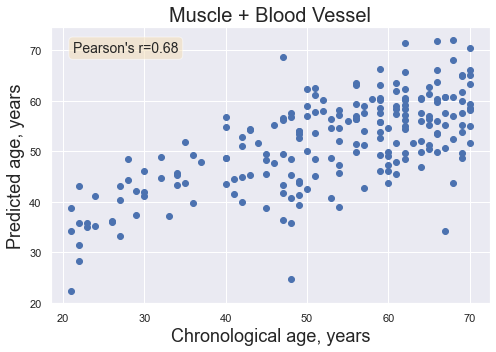

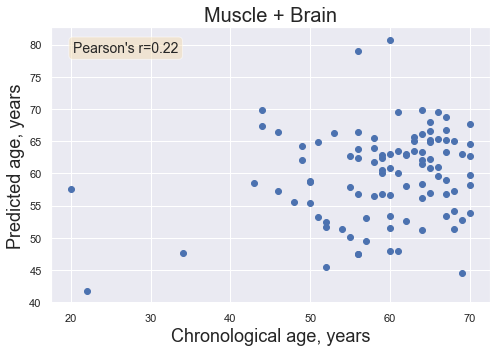

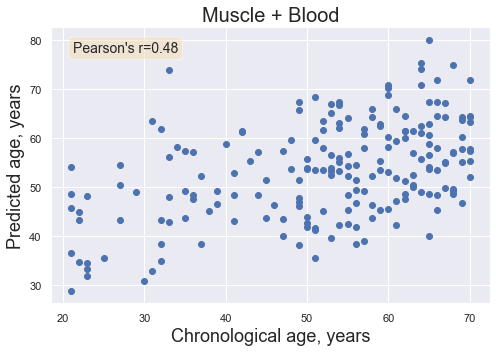

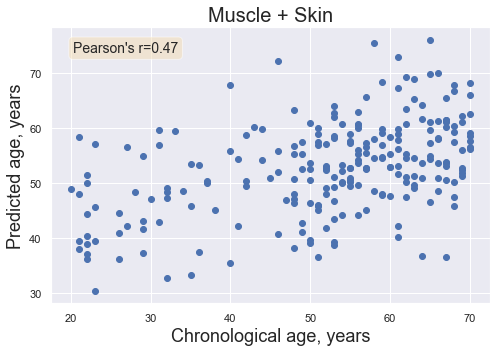

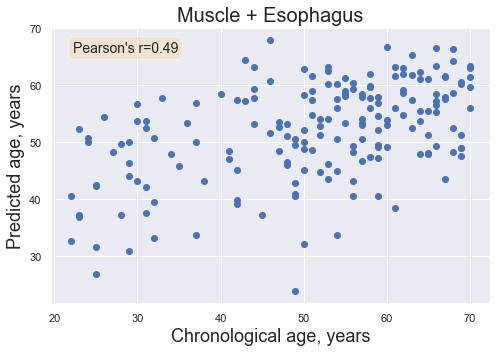

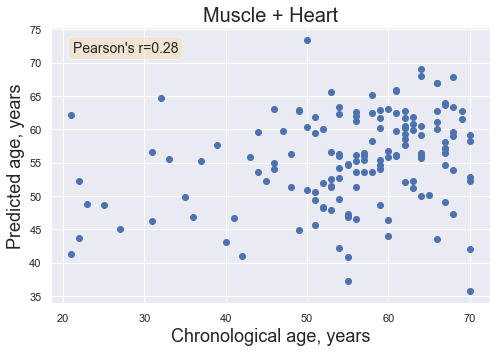

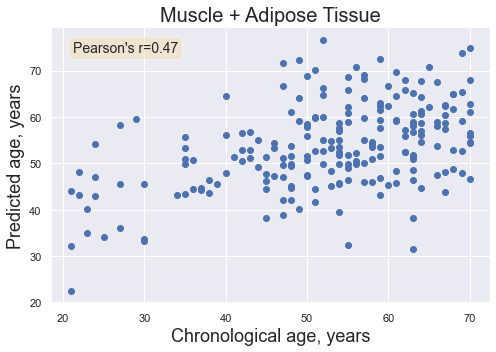

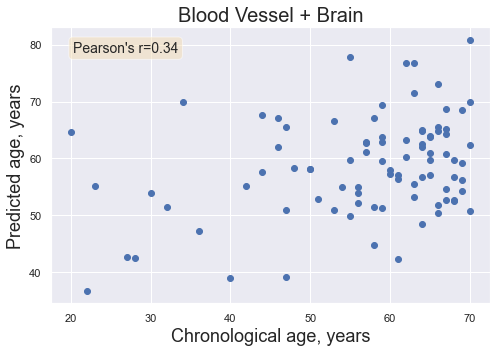

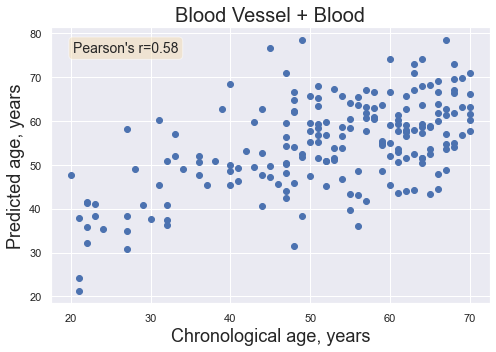

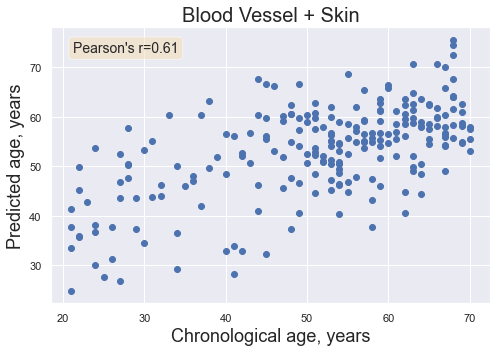

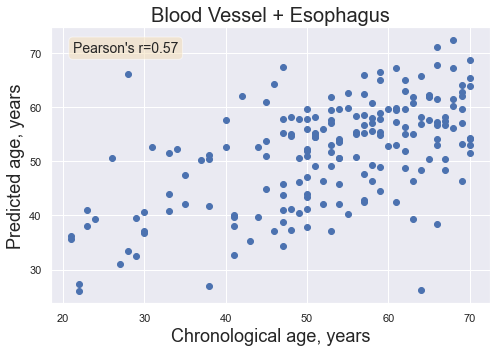

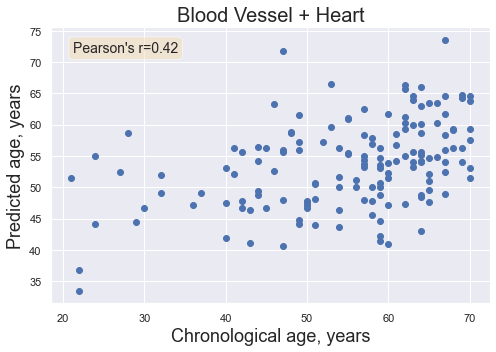

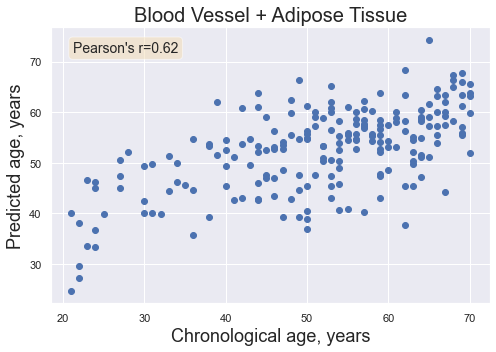

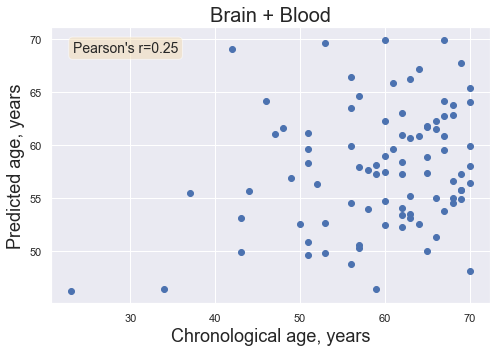

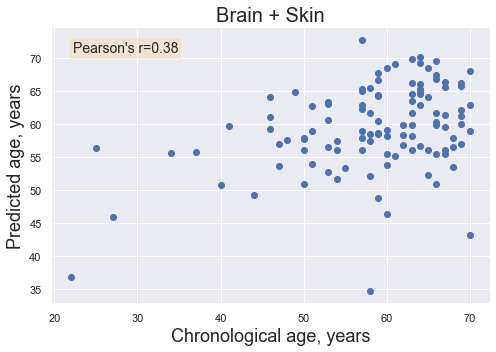

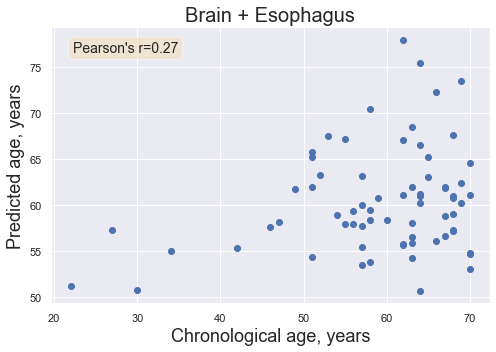

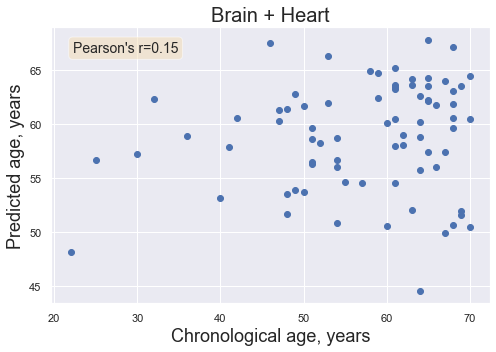

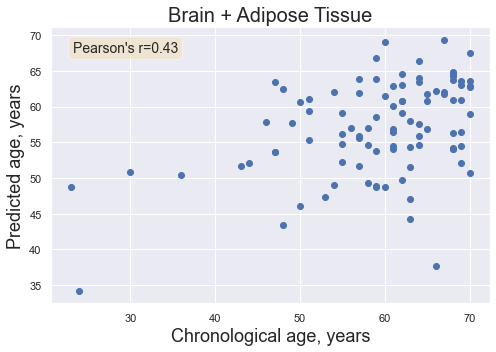

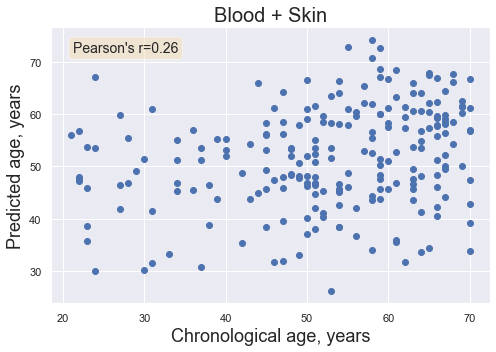

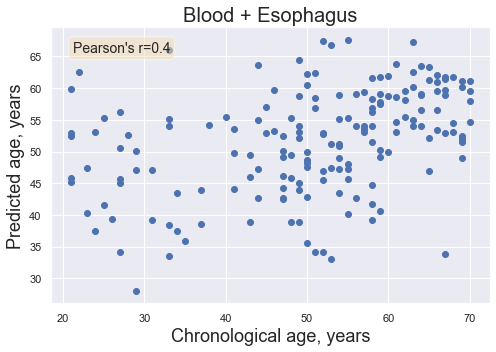

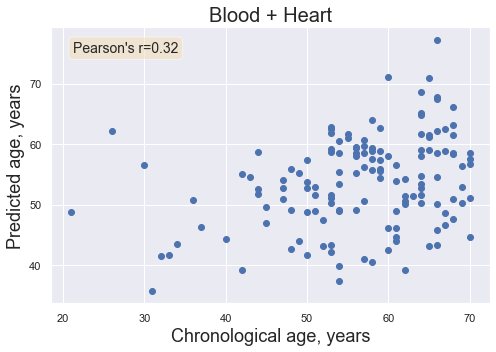

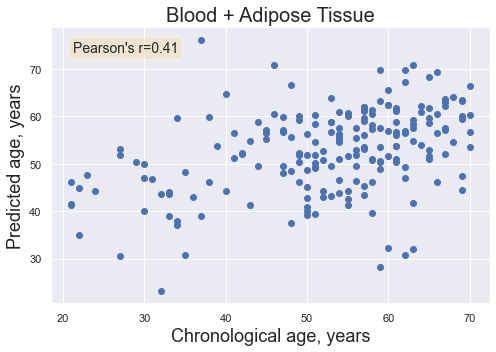

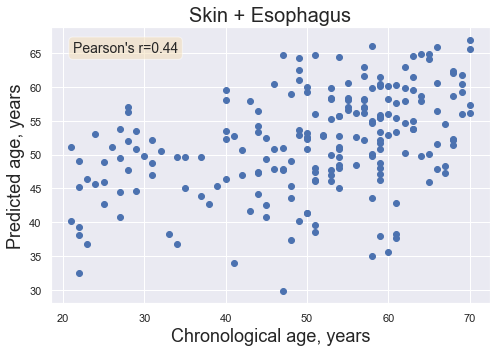

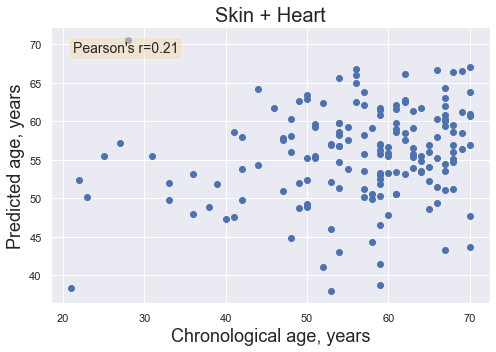

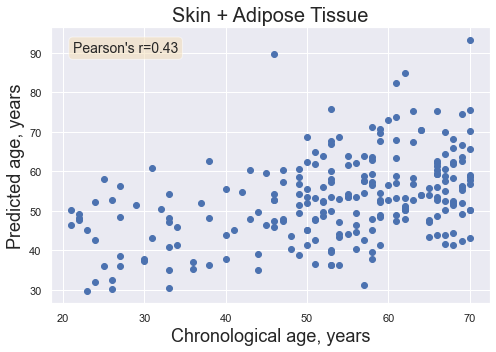

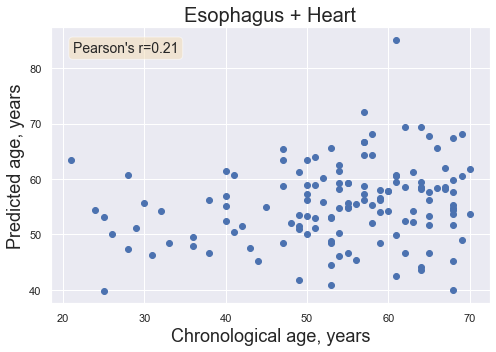

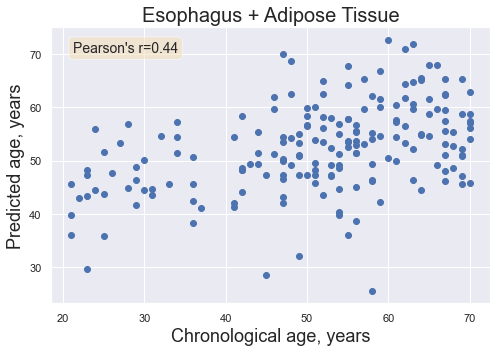

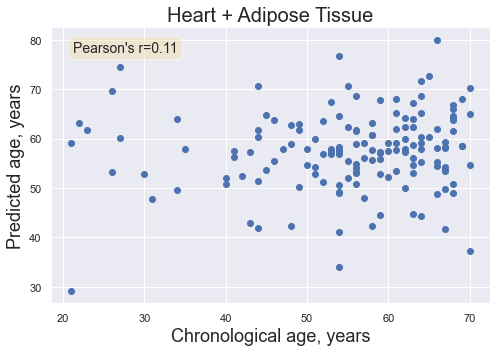

In [259]:
# pearson_corr_new = {}
# true_new = {}
# prediction_new = {}
# data_new = {}
# age_new = {}

# analysis of all pairwise sets of tissues, repeating with new hyperparams
if(mlp == "pairs"):
    for m in range(len(tissueData)):
        for n in range(m+1, len(tissueData)):
            i = tissues[m] # tissue names
            j = tissues[n]
            combineTissue = pd.concat([tissueData[i], tissueData[j]], axis=0, join='inner')
            combineAge = pd.concat([ageData[i], ageData[j]], axis=0, join='inner')
            combineAge = combineAge.iloc[0].values.tolist()
            combineName = i + " + " + j


            data[combineName] = combineTissue
            age[combineName] = combineAge
            print(combineName)

            scalerX = StandardScaler().fit(combineTissue.T)
            scalery = StandardScaler().fit(np.array(combineAge).reshape(-1, 1))
            combine_data_norm = pd.DataFrame(scalerX.transform(combineTissue.T).T)
            combine_ages_norm = scalery.transform(np.array(combineAge).reshape(-1, 1))

            score[combineName], pearson_corr[combineName], true[combineName], prediction[combineName] = fit_mlp_model(combine_data_norm, combine_ages_norm, combineName, scalery, True)
            pearson_corr[combineName] = ss.pearsonr(prediction[combineName], true[combineName])
            print("real pearson", pearson_corr[combineName])

## Train MLP on Original Data

In [260]:
# This section checks for the MLP training on the whole data, with attempting to learn one data point

tissue_num = 2 if runmode != "prod" else len(tissues)
if(mlp == "single"):
    for i, tissue in enumerate(tissues[:tissue_num]):
        # Normalize data
        scalerX = StandardScaler().fit(data[tissue].T)
        scalery = StandardScaler().fit(np.array(age[tissue]).reshape(-1, 1))
        data_norm = scalerX.transform(data[tissue].T).T
        ages_norm = scalery.transform(np.array(age[tissue]).reshape(-1, 1))

        # Run on 10 training points if festing
        points = 10 if runmode != "prod" else data_norm[tissue].shape[1]
        assert(points <= data_norm[tissue].shape[1]) # 803 max

        # This transpose: data_norm[tissue].T.iloc[:points].T is so we can take the first points rows
        score[tissue], pearson_corr[tissue], true[tissue], prediction[tissue] = \
        fit_mlp_model(data_norm[tissue].T.iloc[:points].T, ages_norm[tissue][:points], tissue, scalery, True) # tunes


## Save Results

In [269]:
#Save results

import pickle

# store
# with open('saved_variables/score_' + model_type + '.pickle', 'wb') as handle:
#     pickle.dump(score, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('saved_variables/pearson_corr_' + model_type + '.pickle', 'wb') as handle:
#     pickle.dump(pearson_corr, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('saved_variables/true_' + model_type + '.pickle', 'wb') as handle:
#     pickle.dump(true, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('saved_variables/prediction_' + model_type + '.pickle', 'wb') as handle:
#     pickle.dump(prediction, handle, protocol=pickle.HIGHEST_PROTOCOL)

model_type = "tune_indiv2" + "_" + runmode # only hp tuned on blood vessels

#load
with open('saved_variables/score_' + model_type + '.pickle', 'rb') as handle:
    score_new = pickle.load(handle)
with open('saved_variables/pearson_corr_' + model_type + '.pickle', 'rb') as handle:
    pearson_corr_new = pickle.load(handle)
with open('saved_variables/true_' + model_type + '.pickle', 'rb') as handle:
    true_new = pickle.load(handle)
with open('saved_variables/prediction_' + model_type + '.pickle', 'rb') as handle:
    prediction_new = pickle.load(handle)
    
model_type = "tune_indiv" # only hp tuned on blood vessels

#load
with open('saved_variables/score_' + model_type + '.pickle', 'rb') as handle:
    score = pickle.load(handle)
with open('saved_variables/pearson_corr_' + model_type + '.pickle', 'rb') as handle:
    pearson_corr = pickle.load(handle)
with open('saved_variables/true_' + model_type + '.pickle', 'rb') as handle:
    true = pickle.load(handle)
with open('saved_variables/prediction_' + model_type + '.pickle', 'rb') as handle:
    prediction = pickle.load(handle)
    
print(score, score_new)
    
# with open('score.pickle', 'wb') as handle:
#     score = pickle.load(handle)
# with open('pearson_corr.pickle', 'wb') as handle:
#     pearson_corr = pickle.load(handle)
# with open('true.pickle', 'wb') as handle:
#     true = pickle.load(handle)
# with open('prediction.pickle', 'wb') as handle:
#     prediction = pickle.load(handle)

{'Muscle': -0.23120052659448914, 'Blood Vessel': -0.178688162788524, 'Brain': -0.14630705469415245, 'Blood': -0.25459501011284036, 'Skin': -0.24126493981928993, 'Esophagus': -0.24895808557387394, 'Heart': -0.22856408647931467, 'Adipose Tissue': -0.23414093866578245} {'Muscle + Blood Vessel': -0.8295465717540873, 'Muscle + Brain': -0.977130233513059, 'Muscle + Blood': -0.8666369053876108, 'Muscle + Skin': -0.888646885572987, 'Muscle + Esophagus': -0.9408534992123917, 'Muscle + Heart': -1.0057149224311484, 'Muscle + Adipose Tissue': -0.8422607299065854, 'Blood Vessel + Brain': -0.9506664278657977, 'Blood Vessel + Blood': -0.8171022494796499, 'Blood Vessel + Skin': -0.8212103424297827, 'Blood Vessel + Esophagus': -0.8667673023041006, 'Blood Vessel + Heart': -0.9068534583348274, 'Blood Vessel + Adipose Tissue': -0.8324753901640716, 'Brain + Blood': -1.047900721716107, 'Brain + Skin': -1.0385620132852547, 'Brain + Esophagus': -1.036805728400727, 'Brain + Heart': -1.0404489362567495, 'Brain 

# Additional analysis

### Comparing prediction accuracy for different tissues

KeyError: 'Muscle'

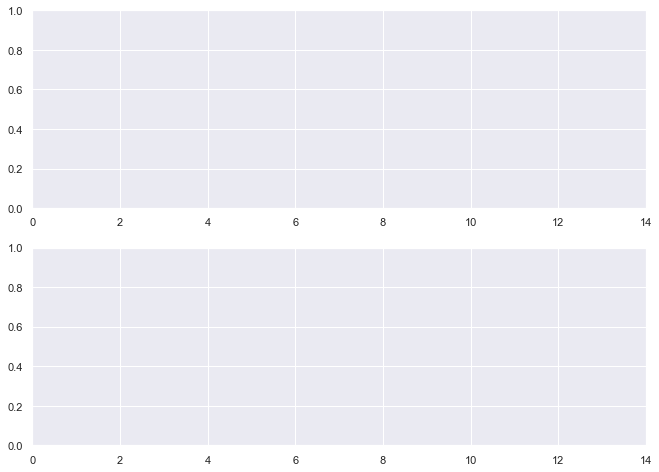

In [262]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11,8))
n=2
x_coords = np.arange(0,n*len(tissues), n)
ax1.set_xticks(np.arange(0,n*len(tissues), n))
ax2.set_xticks(np.arange(0,n*len(tissues), n))
coeff = np.asarray([pearson_corr[tissue][0] for tissue in tissues])
ax1.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax2.set_xticklabels([tissues[i] for i in np.argsort(coeff)[::-1]], rotation=45, fontsize=xlabel_fontsize)
ax2.bar(x_coords, [len(data[tissue].T) for tissue in tissues], \
    color='C1', edgecolor='white', align='center')
ax1.bar(x_coords, width=1, height=coeff[np.argsort(coeff)[::-1]], \
    color='C2', edgecolor='white', align='center')
ax1.set_ylabel('Pearson correlation coefficient', fontsize=ylabel_fontsize)
ax2.set_ylabel('Number of train examples', fontsize=ylabel_fontsize) 
plt.tight_layout()
pp = "/Users/elvirakinzina/src/Aging_clock/Pictures/Number_of_genes_and_correlation." + figure_format
# plt.savefig(pp, format = figure_format)

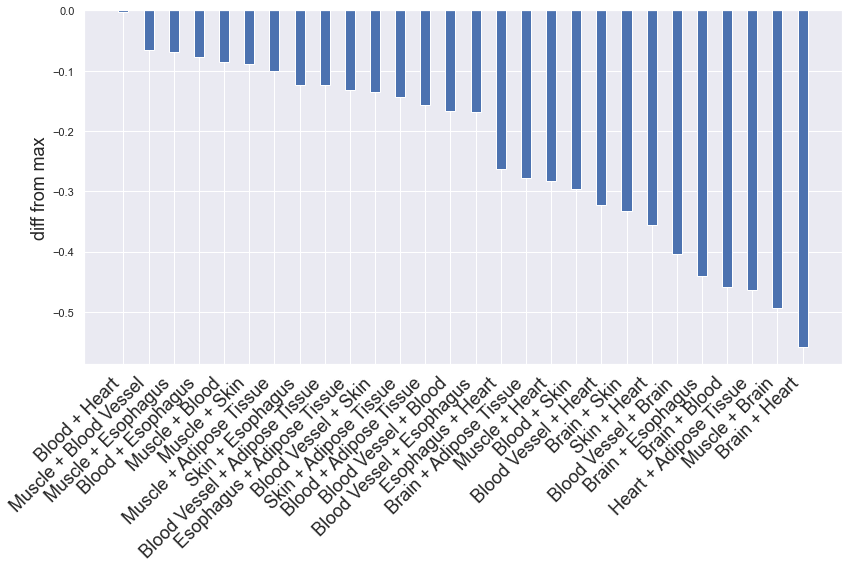

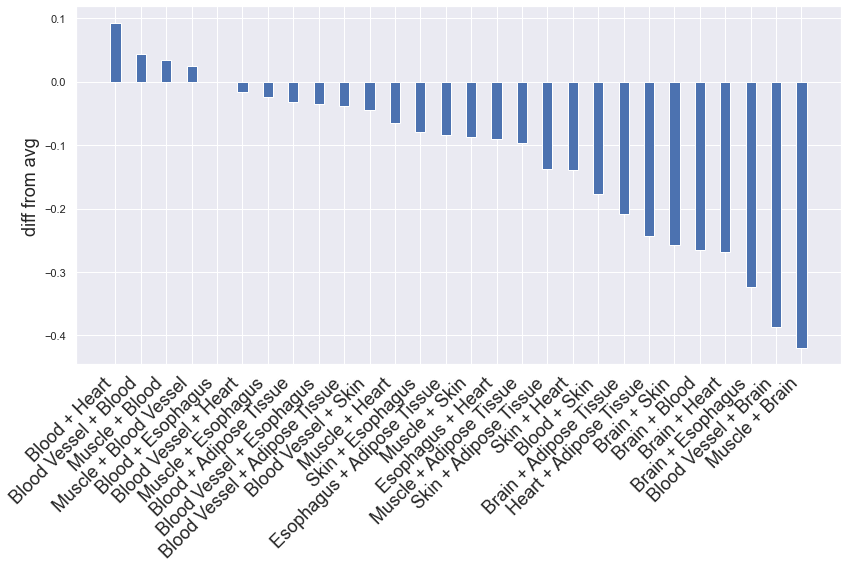

In [270]:
all_names = []
diff_max = []
diff_avg = []

for m in range(len(tissueData)):
    for n in range(m+1, len(tissueData)):
        i = tissues[m] # tissue names
        j = tissues[n]
        combined = [i, j, i + " + " + j]
        all_names.append(i + " + " + j)
        diff_max.append(pearson_corr_new[i + " + " + j][0] - max(pearson_corr[i][0], pearson_corr[j][0]))
        diff_avg.append(pearson_corr_new[i + " + " + j][0] - (pearson_corr[i][0] + pearson_corr[j][0])/2.0)

                    
fig, ax = plt.subplots(figsize=(12,8))
n=2
x_coords = np.arange(0,n*len(all_names), n)
ax.set_xticks(np.arange(0,n*len(all_names), n))
coeff = np.asarray(diff_max)
ax.set_xticklabels([all_names[i] for i in np.argsort(coeff)[::-1]], rotation=45, horizontalalignment='right', fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('diff from max', fontsize=ylabel_fontsize) 
plt.tight_layout()

fig, ax = plt.subplots(figsize=(12,8))
n=2
x_coords = np.arange(0,n*len(all_names), n)
ax.set_xticks(np.arange(0,n*len(all_names), n))
coeff = np.asarray(diff_avg)
ax.set_xticklabels([all_names[i] for i in np.argsort(coeff)[::-1]], rotation=45, horizontalalignment='right', fontsize=xlabel_fontsize)
ax.bar(x_coords, coeff[np.argsort(coeff)[::-1]], \
    color='C0', edgecolor='white')
ax.set_ylabel('diff from avg', fontsize=ylabel_fontsize) 
plt.tight_layout()

## Define most important covariates
These could be included in the model or regressed out to improve age prediction

In [ ]:
def gaussian_project(data, standardize=True, noise=1e-6):
    """ Project each row onto gaussian with matched mean, stdev 

    standardize : bool
        project each row onto N(0, 1), otherwise use N(mu_row, sigma_row),
        where mu_row is the mean of the row and sigma_row is the standard
        deviation
    noise : float
        add random noise drawn from interval (0, noise) to break ties
    """
    # add random noise to break ties
    err = np.random.random(data.shape) * noise
    data = data + err

    ppt = data.rank(axis=1) / (float(data.shape[1])+1.)
    if standardize:
        df = pd.DataFrame(ss.norm.ppf(ppt), index=ppt.index, 
                          columns=ppt.columns)
    else:
        mu = data.mean(axis=1)
        sigma = data.std(axis=1)
        df = {}
        for r in ppt.index:
            df[r] = pd.Series(ss.norm.ppf(ppt.loc[r], loc=mu.loc[r],
                                          scale=sigma.loc[r]), index=ppt.columns)
        df = pd.DataFrame(df).T
    return df
def find_covars_corr_with_first_2_pcs(tissue, data, ax):
        dt = data.copy()
        dt_g = gaussian_project(dt)

        assert(np.sort(np.std(dt_g))[0] > 0)
        print(dt_g.shape)
        assert(dt_g.equals(dt_g.replace(np.inf, np.nan).replace(-np.inf, np.nan).dropna()))
        u, s, vh = np.linalg.svd(dt_g)
        # print(s)
        # print(np.sort(s))
        # pca = PCA().fit(dt_g)
        # u, s, vh = np.linalg.svd(dt_g[:-1, :])
        # # print(s)
        # print(np.sort(s))
        pca = PCA().fit(dt_g)

        # extract principal components
        comps = pd.DataFrame(pca.components_.T, index=dt_g.columns,
                             columns=['PC%i' % (i+1) for i in range(len(pca.components_))])
        
        # choose potential important covariates (add whatever you are interesred in)
        covars = ['SMRIN', 'SMTSISCH', 'TRISCHD', 'ETHNCTY', 'RACE', 'AGE', 'BMI', 'SMNTRNRT', 'DTHRFG', 'DTHVNT', \
                  'SMATSSCR', 'SMALTALG', 'DTHHRDY', 'DTHHRDY']
        print('components', pca.explained_variance_ratio_[0:10])
    
        if np.fabs(sum(pca.explained_variance_ratio_)-1)>0.1:
            print('sum', sum(pca.explained_variance_ratio_))
        
        covs_r = {}
        covs_p = {}
        for pc in ['PC{}'.format(i+1) for i in range(10)]:
            _r = {}
            _p = {}
            for cv in covars:
                if cv in sampleMetaData.columns:
                    covar_vals = np.asarray(sampleMetaData.loc[comps.index, cv])
                elif cv in subjectMetaData.columns:
                    sample_subject_ids = [index.split("-")[0] + "-" + index.split("-")[1] \
                                 for index in list(comps.index)]
                    covar_vals = np.asarray(subjectMetaData.loc[sample_subject_ids, cv])
                _r[cv], _p[cv] = ss.pearsonr(covar_vals[np.isfinite(covar_vals)], \
                                             comps.loc[np.isfinite(covar_vals), pc])
                covs_r[pc] = pd.Series(_r)
                covs_p[pc] = pd.Series(_p)
        covs_r = pd.DataFrame(covs_r).loc[:, ['PC{}'.format(i+1) for i in range(10)]]
        covs_p = pd.DataFrame(covs_p).loc[:, ['PC{}'.format(i+1) for i in range(10)]]

        covarsMain = [covar for covar in covars if (covs_p.loc[covar,:][0:10]<0.05).any()==True]
        first_2_pcs_pars = [covar for covar in covars if (covs_p.loc[covar,:][0:2]<0.05).any()==True]
        ax.set_title(tissue)
        sns.heatmap(-1*np.log10(covs_p.loc[covarsMain,:]), ax=ax, vmax=10, annot=True, fmt=".1f")
        return(first_2_pcs_pars)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Muscle', data['Muscle'], ax)  

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
first_2_pcs_pars = find_covars_corr_with_first_2_pcs('Esophagus', data['Esophagus'], ax)

## Color PCA by parameter (age, RNA quality, ischemic time before) values to explore important parameters for each tissue

You can look at other technical or phenotypic covariates to find those that can possibly explain PCA patterns for tissues that clearly have clusters: skin and esophagus

In [ ]:
def plot_pca_colored_by(data, parameter):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    pca = decomposition.PCA(n_components=2)
    X = data.transpose().copy()
    pca.fit(X)
    y = np.asarray(parameter)
    X = pca.transform(X)
    y_no_na = y[np.where(np.isfinite(y))]
    y_min = np.min(y_no_na)
    y_max = np.max(y_no_na)
    
    for i in range(len(X[:, 0])):
        if np.isfinite(y[i]):
            alpha = float((y[i]-y_min)/float(y_max-y_min))
            ax.scatter(X[i, 0], X[i, 1], color = 'green', alpha = alpha, s=15)

In [ ]:
plot_pca_colored_by(residual_no_outliers["Esophagus"], SMTSISCH["Esophagus"])

## Sample size of each tissue
I chose top 8 tissues for the analysis above

In [ ]:
# tissues = list(set(sampleMetaData['SMTS']))
# sample_num = dict()
# for tissue in tissues:
#         data[tissue], age[tissue], SMRIN[tissue], SMTSISCH[tissue] = load_data(tissue)
#         sample_num[tissue] = data[tissue].shape[1]
# out_file = "/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl"
# with open(out_file, "wb") as f:
#     pickle.dump(sample_num,f,pickle.HIGHEST_PROTOCOL)

In [ ]:
sample_num = pd.read_pickle("/om2/user/elvira/src/data/GTEx_v8/rna_seq/Tissues_sample_numbers.pkl")
tissues = list(sample_num.keys())
sample_numbers = np.asarray([sample_num[tissue] for tissue in tissues])
indices = np.argsort(sample_numbers)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.bar(range(len(tissues)), sample_numbers[indices])
ax.set_xticks(range(len(tissues)))
ax.set_xticklabels([tissues[index] for index in indices], rotation = 90)

## Plot sample age distribution for each tissue
Most samples are from elderly since they die more often

In [ ]:
for tissue in tissues:
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.hist(age[tissue])
    ax.set_title(tissue, fontsize=title_fontsize)